In [10]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm

from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchsampler import ImbalancedDatasetSampler

from scripts.utils import *
from TCN.TCN.tcn import TCN_DimensionalityReduced

In [2]:
from importlib import reload
reload(sys.modules['scripts.utils'])
from scripts.utils import *

In [2]:
sns.set("notebook", "whitegrid")

# Data

In [3]:
train_set = ECGDataset("./data/heartbeats_evensplit_train/", item_transform=hb_transform, target_transform=label_encode)
test_set = ECGDataset("./data/heartbeats_evensplit_test/", target_transform=label_encode)

In [16]:
train_loader = DataLoader(train_set, batch_size=2048, shuffle=True, pin_memory=True, num_workers=8, persistent_workers=True)
test_loader = DataLoader(test_set, batch_size=2048, shuffle=False, pin_memory=True)

In [6]:
from fastai.data.core import DataLoaders

In [17]:
dls = DataLoaders(train_loader, test_loader)

In [7]:
for hb, label in train_loader:
    print(label.shape)
    break

torch.Size([8192])


In [9]:
label_counts = {}
for label in train_set.y:
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1
total_labels = sum(label_counts.values())
class_weights = {label: total_labels / count for label, count in label_counts.items()}
class_weights = torch.tensor(list(class_weights.values()))
class_weights /= class_weights.max()
class_weights

tensor([7.4816e-04, 3.9521e-02, 1.0141e-02, 5.5276e-03, 1.0000e+00])

# Model

In [4]:
from torchinfo import summary

In [9]:
from fastai.learner import Learner
from fastai.metrics import accuracy, Precision, Recall, F1Score, RocAuc
from fastai.callback.schedule import valley, slide, minimum, steep
from fastai.callback.fp16 import MixedPrecision
import fastai.callback.schedule

In [14]:
torch.autograd.set_detect_anomaly(True)

In [16]:
model = TCN(360, 5, [32]*9, 2, 0.125, use_skip_connections=True)
summary(model, input_size=(2048, 360), dtypes=[torch.float16], device="cuda")

Layer (type:depth-idx)                   Output Shape              Param #
TCN                                      [2048, 5]                 --
├─TCN_DimensionalityReduced: 1-1         [2048, 32, 360]           --
│    └─Conv1d: 2-1                       [2048, 32, 360]           64
│    └─Sequential: 2-2                   [2048, 32, 360]           --
│    │    └─TemporalSkipBlock: 3-1       [2048, 32, 360]           5,280
│    │    └─TemporalSkipBlock: 3-2       [2048, 32, 360]           5,280
│    │    └─TemporalSkipBlock: 3-3       [2048, 32, 360]           5,280
│    │    └─TemporalSkipBlock: 3-4       [2048, 32, 360]           5,280
│    │    └─TemporalSkipBlock: 3-5       [2048, 32, 360]           5,280
│    │    └─TemporalSkipBlock: 3-6       [2048, 32, 360]           5,280
│    │    └─TemporalSkipBlock: 3-7       [2048, 32, 360]           5,280
│    │    └─TemporalSkipBlock: 3-8       [2048, 32, 360]           5,280
│    │    └─TemporalSkipBlock: 3-9       [2048, 32, 360]     

In [19]:
torch.cuda.empty_cache()

wd: 1e-05, min: 1.78e-02, steepest: 1.78e-03, valley: 6.31e-03, slide: 3.16e-02


wd: 3e-05, min: 7.94e-03, steepest: 2.00e-03, valley: 4.47e-03, slide: 1.58e-03


wd: 0.0001, min: 7.08e-03, steepest: 1.41e-03, valley: 4.47e-03, slide: 1.26e-03


wd: 0.0003, min: 2.00e-02, steepest: 1.78e-03, valley: 7.08e-03, slide: 1.58e-03


wd: 0, min: 1.58e-02, steepest: 1.78e-03, valley: 6.31e-03, slide: 2.82e-02


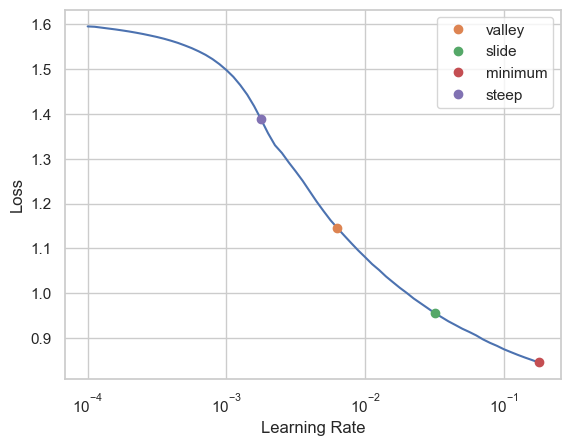

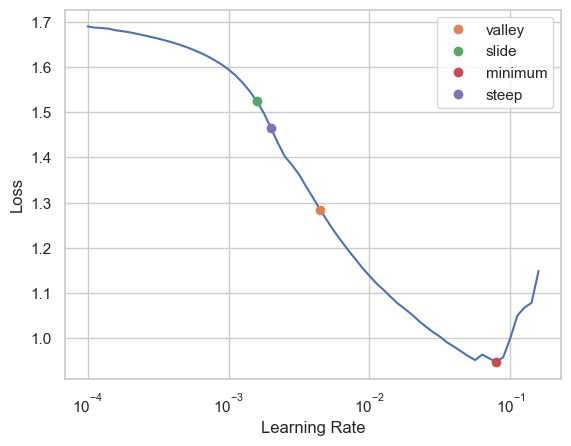

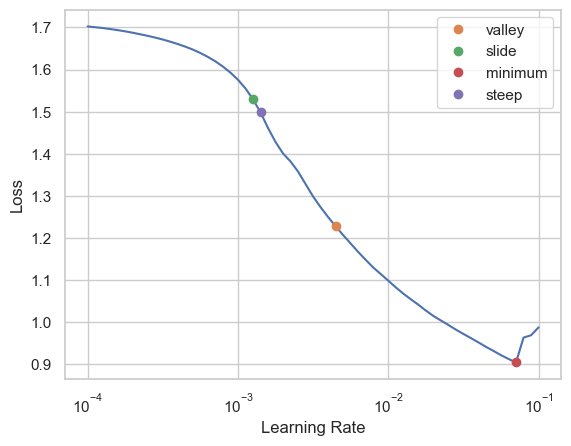

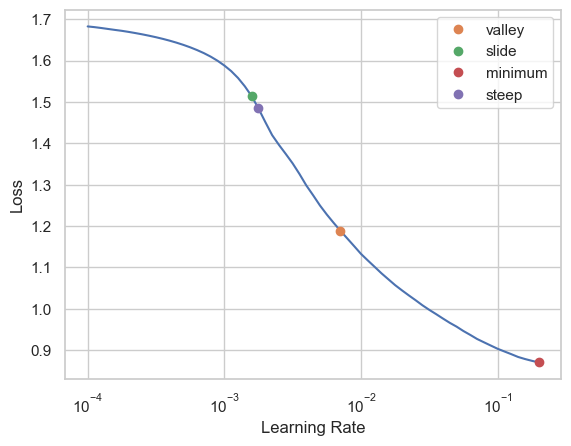

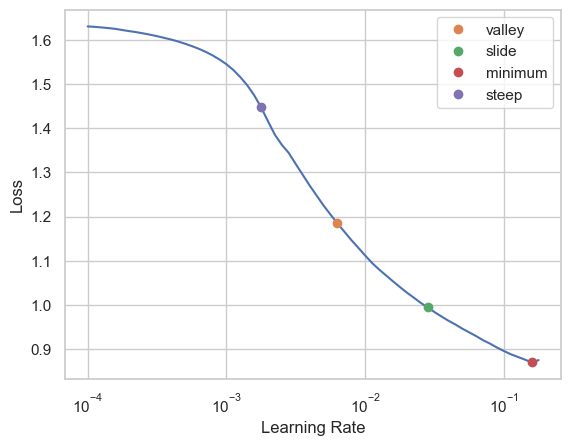

In [18]:
learners = []
suggestions = []
for wd in [1e-5, 3e-5, 1e-4, 3e-4, 0]:
    learn = Learner(
        dls=dls,
        model=TCN(360, 5, [32]*9, 2, 0.125, use_skip_connections=True).cuda(),
        loss_func=nn.CrossEntropyLoss(),
        metrics=[accuracy, Precision(average="macro"), Recall(average="macro"), F1Score(average="macro"), RocAuc(average="macro")],
        path="./models/tcn",
        wd=wd,
    )
    suggestion = learn.lr_find(1e-4, 10.0, stop_div=True, suggest_funcs=[valley, slide, minimum, steep])
    suggestions.append(suggestion)
    print(f"wd: {wd}, min: {suggestion.minimum:.2e}, steepest: {suggestion.steep:.2e}, valley: {suggestion.valley:.2e}, slide: {suggestion.slide:.2e}")
    # learn.recorder.plot_lr_find()
    learners.append(learn)
dls[0]._iterator._shutdown_workers()

# Training

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, precision_recall_curve
from fastai.callback.core import Callback
from fastai.callback.fp16 import MixedPrecision
from fastai.callback.progress import ProgressCallback, ShowGraphCallback, CSVLogger
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.schedule import fit_one_cycle
from fastai.metrics import skm_to_fastai

In [6]:
import json

In [25]:
if os.path.exists('models/prototyping/model.json'):
    with open('models/prototyping/model.json') as f:
        interruptable_info = json.load(f)
else:
    interruptable_info = {
        "fold": 0,
        "epoch": 0
    }
    with open('models/prototyping/model.json', 'x') as f:
        json.dump(interruptable_info, f, indent=4)

In [7]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
train_ys = np.array([y for y in train_set.y])

In [8]:
class LogInterruptable(Callback):
    def after_epoch(self):
        interruptable_info["epoch"] = self.epoch
        with open('models/prototyping/model.json', 'w') as f:
            json.dump(interruptable_info, f, indent=4)

In [9]:
def fastai_precision_score(axis=-1, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn'):
    return skm_to_fastai(precision_score, axis=axis, labels=labels, pos_label=pos_label, average=average, sample_weight=sample_weight, zero_division=zero_division)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,1.593776,1.586247,0.057443,0.011489,0.200000,0.021729,0.437048,00:24
1,1.559006,1.538198,0.082767,0.016555,0.200000,0.030579,0.529316,00:25
2,1.515475,1.480194,0.082767,0.016553,0.200000,0.030576,0.515169,00:25
3,1.458531,1.405332,0.082767,0.016553,0.200000,0.030576,0.521294,00:25
4,1.382083,1.301335,0.082767,0.016553,0.200000,0.030576,0.640836,00:24
5,1.261126,1.087623,0.082767,0.016553,0.200000,0.030576,0.625069,00:24
6,1.040825,1.001863,0.082767,0.016560,0.200000,0.030588,0.625729,00:24
7,0.857415,0.843659,0.082767,0.016567,0.200000,0.030599,0.589784,00:25
8,0.728596,0.816604,0.082767,0.016574,0.200000,0.030611,0.590631,00:24
9,0.635553,0.763076,0.082973,0.041596,0.200717,0.032043,0.596655,00:24


Better model found at epoch 0 with valid_loss value: 1.5862473249435425.


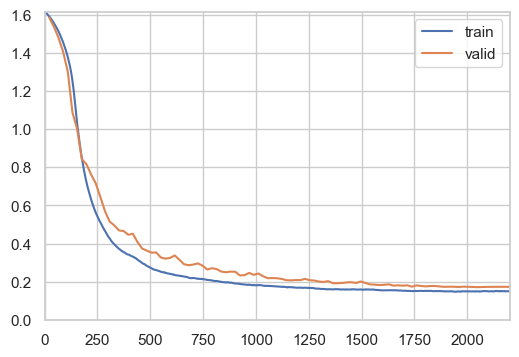

Better model found at epoch 1 with valid_loss value: 1.5381981134414673.
Better model found at epoch 2 with valid_loss value: 1.480193853378296.
Better model found at epoch 3 with valid_loss value: 1.4053318500518799.
Better model found at epoch 4 with valid_loss value: 1.3013349771499634.
Better model found at epoch 5 with valid_loss value: 1.0876234769821167.
Better model found at epoch 6 with valid_loss value: 1.0018630027770996.
Better model found at epoch 7 with valid_loss value: 0.8436591029167175.
Better model found at epoch 8 with valid_loss value: 0.816604495048523.
Better model found at epoch 9 with valid_loss value: 0.7630762457847595.
Better model found at epoch 10 with valid_loss value: 0.7160434126853943.
Better model found at epoch 11 with valid_loss value: 0.6440597772598267.
Better model found at epoch 12 with valid_loss value: 0.5696802735328674.
Better model found at epoch 13 with valid_loss value: 0.5154771208763123.
Better model found at epoch 14 with valid_loss va

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,2.280231,2.128247,0.829216,0.165843,0.200000,0.181327,0.405020,00:25
1,2.267294,2.109527,0.829216,0.165843,0.200000,0.181327,0.467580,00:25
2,2.248443,2.074903,0.829216,0.165843,0.200000,0.181327,0.498046,00:25
3,2.214427,2.008985,0.829216,0.165843,0.200000,0.181327,0.538352,00:24
4,2.138490,1.811232,0.829216,0.165843,0.200000,0.181327,0.547104,00:25
5,1.804210,1.370620,0.082767,0.016553,0.200000,0.030576,0.466339,00:24
6,1.413976,0.941060,0.082767,0.016553,0.200000,0.030576,0.462464,00:25
7,1.126089,0.943965,0.082767,0.016553,0.200000,0.030576,0.472957,00:24
8,0.937445,0.939030,0.082767,0.016553,0.200000,0.030576,0.487537,00:25
9,0.813925,0.959269,0.082767,0.016553,0.200000,0.030576,0.495608,00:24


Better model found at epoch 0 with valid_loss value: 2.1282474994659424.


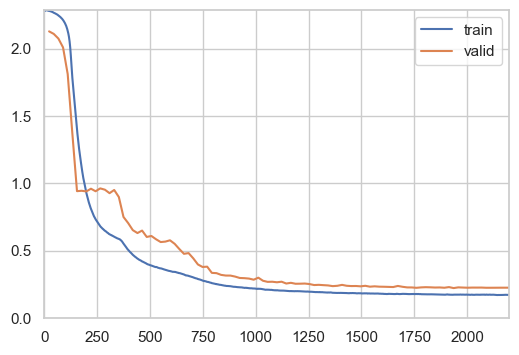

Better model found at epoch 1 with valid_loss value: 2.109527111053467.
Better model found at epoch 2 with valid_loss value: 2.0749027729034424.
Better model found at epoch 3 with valid_loss value: 2.0089850425720215.
Better model found at epoch 4 with valid_loss value: 1.811232328414917.
Better model found at epoch 5 with valid_loss value: 1.3706196546554565.
Better model found at epoch 6 with valid_loss value: 0.9410601258277893.
Better model found at epoch 8 with valid_loss value: 0.9390295147895813.
Better model found at epoch 13 with valid_loss value: 0.9260560870170593.
Better model found at epoch 15 with valid_loss value: 0.8973909616470337.
Better model found at epoch 16 with valid_loss value: 0.7491477727890015.
Better model found at epoch 17 with valid_loss value: 0.7041212916374207.
Better model found at epoch 18 with valid_loss value: 0.6514153480529785.
Better model found at epoch 19 with valid_loss value: 0.6297409534454346.
Better model found at epoch 21 with valid_loss 

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,1.205941,1.286430,0.082767,0.016553,0.200000,0.030576,0.416713,00:25
1,1.176684,1.249266,0.082767,0.016553,0.200000,0.030576,0.562740,00:25
2,1.138243,1.201043,0.082767,0.016553,0.200000,0.030576,0.575418,00:25
3,1.085604,1.139051,0.082767,0.016553,0.200000,0.030576,0.596337,00:25
4,1.009696,1.048968,0.082767,0.016553,0.200000,0.030576,0.606231,00:24
5,0.895872,1.003105,0.082767,0.016553,0.200000,0.030576,0.583072,00:25
6,0.788332,1.089027,0.082767,0.016553,0.200000,0.030576,0.576433,00:24
7,0.711583,0.975687,0.082767,0.016553,0.200000,0.030576,0.585301,00:25
8,0.658800,0.974417,0.082767,0.016553,0.200000,0.030576,0.589270,00:24
9,0.617618,0.928798,0.082767,0.016553,0.200000,0.030576,0.605477,00:25


Better model found at epoch 0 with valid_loss value: 1.286429762840271.


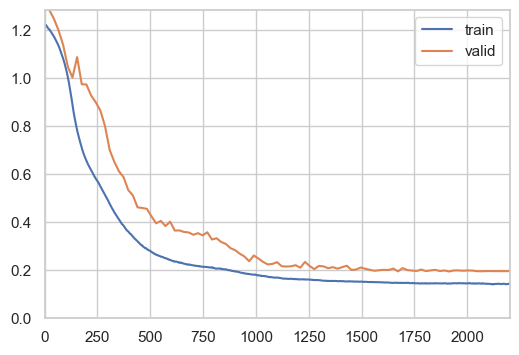

Better model found at epoch 1 with valid_loss value: 1.2492655515670776.
Better model found at epoch 2 with valid_loss value: 1.2010430097579956.
Better model found at epoch 3 with valid_loss value: 1.1390513181686401.
Better model found at epoch 4 with valid_loss value: 1.0489678382873535.
Better model found at epoch 5 with valid_loss value: 1.003104567527771.
Better model found at epoch 7 with valid_loss value: 0.9756872653961182.
Better model found at epoch 8 with valid_loss value: 0.974416971206665.
Better model found at epoch 9 with valid_loss value: 0.9287976026535034.
Better model found at epoch 10 with valid_loss value: 0.9005703926086426.
Better model found at epoch 11 with valid_loss value: 0.8655713796615601.
Better model found at epoch 12 with valid_loss value: 0.8004077672958374.
Better model found at epoch 13 with valid_loss value: 0.7012335658073425.
Better model found at epoch 14 with valid_loss value: 0.6515628695487976.
Better model found at epoch 15 with valid_loss v

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,1.470842,1.501083,0.084826,0.027968,0.299751,0.051117,0.597711,00:25
1,1.459059,1.482389,0.082870,0.018690,0.204762,0.033653,0.574061,00:25
2,1.440190,1.449316,0.082767,0.016576,0.200000,0.030614,0.488474,00:25
3,1.405237,1.382653,0.082767,0.016553,0.200000,0.030576,0.494465,00:24
4,1.299121,1.008512,0.082767,0.016553,0.200000,0.030576,0.594424,00:25
5,1.057706,0.926863,0.082767,0.016553,0.200000,0.030576,0.609659,00:25
6,0.885728,0.980993,0.082767,0.016553,0.200000,0.030576,0.617511,00:24
7,0.764896,0.910229,0.082767,0.016553,0.200000,0.030576,0.591858,00:24
8,0.684759,0.880973,0.082767,0.016553,0.200000,0.030576,0.571668,00:25
9,0.628826,0.839787,0.082767,0.016553,0.200000,0.030576,0.570889,00:25


Better model found at epoch 0 with valid_loss value: 1.5010827779769897.


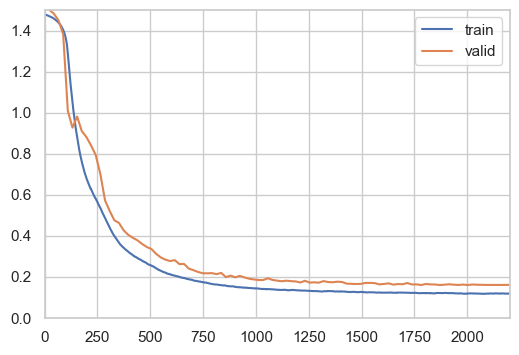

Better model found at epoch 1 with valid_loss value: 1.4823894500732422.
Better model found at epoch 2 with valid_loss value: 1.449316382408142.
Better model found at epoch 3 with valid_loss value: 1.3826534748077393.
Better model found at epoch 4 with valid_loss value: 1.0085119009017944.
Better model found at epoch 5 with valid_loss value: 0.9268627762794495.
Better model found at epoch 7 with valid_loss value: 0.9102285504341125.
Better model found at epoch 8 with valid_loss value: 0.8809728026390076.
Better model found at epoch 9 with valid_loss value: 0.8397866487503052.
Better model found at epoch 10 with valid_loss value: 0.7935190796852112.
Better model found at epoch 11 with valid_loss value: 0.7002895474433899.
Better model found at epoch 12 with valid_loss value: 0.5727553367614746.
Better model found at epoch 13 with valid_loss value: 0.5208471417427063.
Better model found at epoch 14 with valid_loss value: 0.47546684741973877.
Better model found at epoch 15 with valid_loss

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,2.290513,2.114567,0.026251,0.005250,0.200000,0.010232,0.432187,00:25
1,2.253968,2.058233,0.026251,0.005250,0.200000,0.010232,0.438610,00:25
2,2.203889,1.983549,0.026251,0.005250,0.200000,0.010232,0.443493,00:25
3,2.129468,1.851357,0.026251,0.005250,0.200000,0.010232,0.528147,00:24
4,1.927927,1.132574,0.082767,0.016553,0.200000,0.030576,0.674615,00:25
5,1.485238,1.025533,0.082767,0.016553,0.200000,0.030576,0.671883,00:24
6,1.166164,0.908840,0.082767,0.016553,0.200000,0.030576,0.680966,00:25
7,0.952559,0.862991,0.082767,0.016553,0.200000,0.030576,0.627416,00:25
8,0.808447,0.868601,0.082767,0.016553,0.200000,0.030576,0.597266,00:24
9,0.704727,0.801305,0.082767,0.016553,0.200000,0.030576,0.580135,00:25


Better model found at epoch 0 with valid_loss value: 2.1145670413970947.


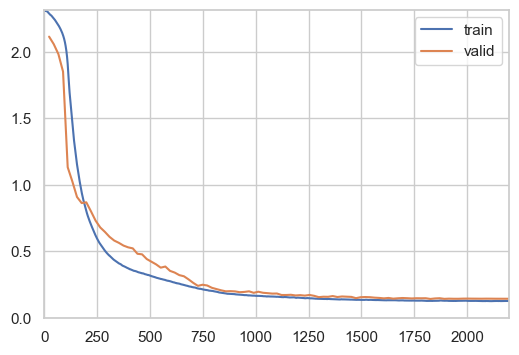

Better model found at epoch 1 with valid_loss value: 2.0582327842712402.
Better model found at epoch 2 with valid_loss value: 1.9835492372512817.
Better model found at epoch 3 with valid_loss value: 1.8513572216033936.
Better model found at epoch 4 with valid_loss value: 1.1325740814208984.
Better model found at epoch 5 with valid_loss value: 1.0255329608917236.
Better model found at epoch 6 with valid_loss value: 0.9088404178619385.
Better model found at epoch 7 with valid_loss value: 0.862991213798523.
Better model found at epoch 9 with valid_loss value: 0.8013046383857727.
Better model found at epoch 10 with valid_loss value: 0.7306843400001526.
Better model found at epoch 11 with valid_loss value: 0.6795281171798706.
Better model found at epoch 12 with valid_loss value: 0.6462292075157166.
Better model found at epoch 13 with valid_loss value: 0.6087934970855713.
Better model found at epoch 14 with valid_loss value: 0.5810191035270691.
Better model found at epoch 15 with valid_loss 

: 

In [26]:
learners = []
for idx, (train_index, val_index) in enumerate(skf.split(np.zeros(len(train_ys)), train_ys)):
    tcn_model = TCN(360, 5, [2]*9, 32, 0.125, use_skip_connections=True).cuda()
    if idx < interruptable_info["fold"]:
        continue
    train_fold_set = Subset(train_set, train_index)
    val_fold_set = Subset(train_set, val_index)
    train_fold_loader = DataLoader(train_fold_set, batch_size=4096, shuffle=True, pin_memory=True)
    val_fold_loader = DataLoader(val_fold_set, batch_size=4096, shuffle=False, pin_memory=True)
    fold_dls = DataLoaders(train_fold_loader, val_fold_loader)
    best_model_cb = SaveModelCallback(monitor="valid_loss", fname=f"best")
    every_epoch_save_cb = SaveModelCallback(monitor="valid_loss", fname=f"epoch", every_epoch=True)
    csv_logger = CSVLogger(fname=f"./models/prototyping/tcn_fold_{idx+1}/log.csv", append=True)
    learn = Learner(
        dls=fold_dls,
        model=tcn_model,
        model_dir=f"./models/prototyping/tcn_fold_{idx+1}/",
        loss_func=nn.CrossEntropyLoss(weight=class_weights.cuda()),
        cbs=[MixedPrecision()],
        metrics=[accuracy, fastai_precision_score(average="macro", zero_division=0.0), Recall(average="macro"), F1Score(average="macro"), RocAuc(average="macro")]
    )
    if interruptable_info["epoch"] != 0 and os.path.exists(f"./models/prototyping/tcn_fold_{idx + 1}/epoch_{interruptable_info['epoch'] + 1}.pth"):
        learn = learn.load(f"./models/prototyping/tcn_fold_{idx + 1}/epoch_{interruptable_info['epoch'] + 1}.pth")
    learn.fit_one_cycle(
        n_epoch=100,
        lr_max=3e-3,
        div=10.0,
        start_epoch=interruptable_info["epoch"],
        wd=3e-4,
        cbs=[best_model_cb, every_epoch_save_cb, csv_logger, LogInterruptable(), ShowGraphCallback()],
    )
    learners.append(learn)
    interruptable_info["epoch"] = 0
    interruptable_info["fold"] += 1
    json.dump(interruptable_info, open('models/prototyping/model.json', 'w'), indent=4)

## Use half the dataset for testing

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.390230,1.382359,0.110148,0.022030,0.200000,0.039688,00:30
1,1.381964,1.368287,0.110148,0.022030,0.200000,0.039688,00:05
2,1.373517,1.354080,0.110148,0.022030,0.200000,0.039688,00:06
3,1.363942,1.335860,0.110148,0.022030,0.200000,0.039688,00:06
4,1.351687,1.309834,0.110148,0.022030,0.200000,0.039688,00:05
5,1.335171,1.272375,0.110148,0.022030,0.200000,0.039688,00:05
6,1.312260,1.218394,0.110148,0.022030,0.200000,0.039688,00:05
7,1.279244,1.134288,0.110148,0.022030,0.200000,0.039688,00:05
8,1.232039,1.016511,0.110148,0.022030,0.200000,0.039688,00:05
9,1.160334,0.807775,0.110148,0.022030,0.200000,0.039688,00:06


Better model found at epoch 0 with valid_loss value: 1.3823593854904175.


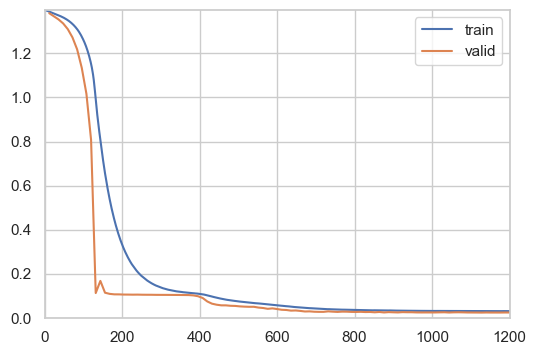

Better model found at epoch 1 with valid_loss value: 1.3682866096496582.
Better model found at epoch 2 with valid_loss value: 1.3540797233581543.
Better model found at epoch 3 with valid_loss value: 1.3358598947525024.
Better model found at epoch 4 with valid_loss value: 1.309834361076355.
Better model found at epoch 5 with valid_loss value: 1.272375226020813.
Better model found at epoch 6 with valid_loss value: 1.2183939218521118.
Better model found at epoch 7 with valid_loss value: 1.1342878341674805.
Better model found at epoch 8 with valid_loss value: 1.0165109634399414.
Better model found at epoch 9 with valid_loss value: 0.8077748417854309.
Better model found at epoch 10 with valid_loss value: 0.11220844089984894.
Better model found at epoch 13 with valid_loss value: 0.1086372509598732.
Better model found at epoch 14 with valid_loss value: 0.10646429657936096.
Better model found at epoch 15 with valid_loss value: 0.10633189976215363.
Better model found at epoch 16 with valid_loss

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.587266,1.576272,0.813838,0.162768,0.200000,0.179473,00:29
1,1.575007,1.552603,0.813838,0.162768,0.200000,0.179473,00:06
2,1.560402,1.524657,0.813838,0.162768,0.200000,0.179473,00:05
3,1.542597,1.490040,0.813838,0.162768,0.200000,0.179473,00:05
4,1.520297,1.444977,0.813838,0.162768,0.200000,0.179473,00:05
5,1.491693,1.385450,0.805351,0.166584,0.198204,0.179069,00:05
6,1.454359,1.304677,0.729151,0.168630,0.185271,0.176464,00:05
7,1.404395,1.188806,0.118819,0.193164,0.202131,0.044263,00:05
8,1.328410,0.909349,0.110886,0.222046,0.200181,0.040076,00:05
9,1.138284,0.135678,0.110148,0.022030,0.200000,0.039688,00:05


Better model found at epoch 0 with valid_loss value: 1.5762720108032227.


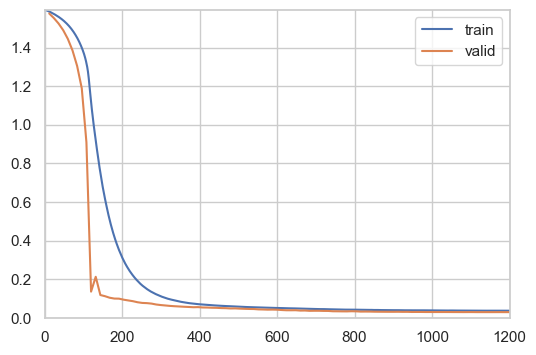

Better model found at epoch 1 with valid_loss value: 1.552603006362915.
Better model found at epoch 2 with valid_loss value: 1.5246574878692627.
Better model found at epoch 3 with valid_loss value: 1.4900397062301636.
Better model found at epoch 4 with valid_loss value: 1.444977045059204.
Better model found at epoch 5 with valid_loss value: 1.3854502439498901.
Better model found at epoch 6 with valid_loss value: 1.3046767711639404.
Better model found at epoch 7 with valid_loss value: 1.1888059377670288.
Better model found at epoch 8 with valid_loss value: 0.9093491435050964.
Better model found at epoch 9 with valid_loss value: 0.13567817211151123.
Better model found at epoch 11 with valid_loss value: 0.11800295859575272.
Better model found at epoch 12 with valid_loss value: 0.11190326511859894.
Better model found at epoch 13 with valid_loss value: 0.10398197174072266.
Better model found at epoch 14 with valid_loss value: 0.09968128800392151.
Better model found at epoch 15 with valid_lo

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.364491,1.355340,0.813838,0.162768,0.200000,0.179473,00:28
1,1.354395,1.336502,0.813838,0.162768,0.200000,0.179473,00:05
2,1.342616,1.313957,0.813838,0.162768,0.200000,0.179473,00:05
3,1.328159,1.285447,0.813838,0.162768,0.200000,0.179473,00:05
4,1.309795,1.247646,0.813838,0.162768,0.200000,0.179473,00:05
5,1.285902,1.197041,0.811255,0.162671,0.199365,0.179159,00:05
6,1.254334,1.128822,0.145203,0.216731,0.208325,0.057542,00:05
7,1.212379,1.037984,0.115129,0.222140,0.201224,0.042300,00:05
8,1.156900,0.919462,0.111624,0.222062,0.200363,0.040465,00:05
9,1.084805,0.772964,0.110332,0.222034,0.200045,0.039785,00:05


Better model found at epoch 0 with valid_loss value: 1.355339765548706.


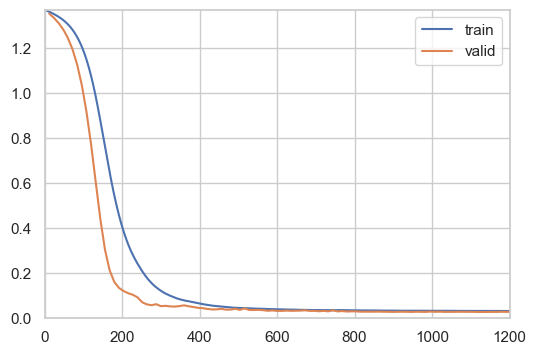

Better model found at epoch 1 with valid_loss value: 1.3365023136138916.
Better model found at epoch 2 with valid_loss value: 1.3139572143554688.
Better model found at epoch 3 with valid_loss value: 1.2854470014572144.
Better model found at epoch 4 with valid_loss value: 1.2476458549499512.
Better model found at epoch 5 with valid_loss value: 1.1970407962799072.
Better model found at epoch 6 with valid_loss value: 1.1288224458694458.
Better model found at epoch 7 with valid_loss value: 1.037984013557434.
Better model found at epoch 8 with valid_loss value: 0.9194619655609131.
Better model found at epoch 9 with valid_loss value: 0.7729640007019043.
Better model found at epoch 10 with valid_loss value: 0.6052711606025696.
Better model found at epoch 11 with valid_loss value: 0.43916571140289307.
Better model found at epoch 12 with valid_loss value: 0.3026221990585327.
Better model found at epoch 13 with valid_loss value: 0.21124717593193054.
Better model found at epoch 14 with valid_loss

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.545406,1.528821,0.060148,0.012030,0.200000,0.022694,00:29
1,1.527339,1.496007,0.060148,0.012030,0.200000,0.022694,00:05
2,1.507285,1.459131,0.060148,0.012030,0.200000,0.022694,00:05
3,1.483230,1.412495,0.060148,0.012030,0.200000,0.022694,00:05
4,1.453410,1.353882,0.059963,0.012095,0.199387,0.022807,00:05
5,1.414967,1.267528,0.110148,0.022030,0.200000,0.039688,00:05
6,1.354752,1.060657,0.110148,0.022030,0.200000,0.039688,00:06
7,1.183459,0.157549,0.110148,0.022030,0.200000,0.039688,00:05
8,0.937589,0.196303,0.110148,0.022030,0.200000,0.039688,00:05
9,0.761384,0.120071,0.110148,0.022030,0.200000,0.039688,00:05


Better model found at epoch 0 with valid_loss value: 1.528820514678955.


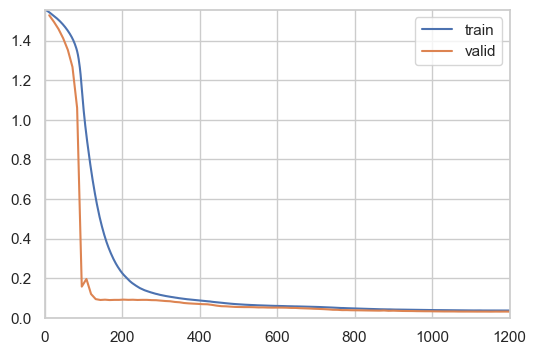

Better model found at epoch 1 with valid_loss value: 1.4960073232650757.
Better model found at epoch 2 with valid_loss value: 1.4591313600540161.
Better model found at epoch 3 with valid_loss value: 1.4124945402145386.
Better model found at epoch 4 with valid_loss value: 1.3538824319839478.
Better model found at epoch 5 with valid_loss value: 1.2675280570983887.
Better model found at epoch 6 with valid_loss value: 1.0606565475463867.
Better model found at epoch 7 with valid_loss value: 0.1575489491224289.
Better model found at epoch 9 with valid_loss value: 0.12007103860378265.
Better model found at epoch 10 with valid_loss value: 0.0943765863776207.
Better model found at epoch 11 with valid_loss value: 0.09012269973754883.
Better model found at epoch 13 with valid_loss value: 0.08971976488828659.
Better model found at epoch 22 with valid_loss value: 0.08938929438591003.
Better model found at epoch 23 with valid_loss value: 0.08895367383956909.
Better model found at epoch 24 with valid

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.865070,1.855154,0.060148,0.012030,0.200000,0.022694,00:29
1,1.854023,1.833992,0.060148,0.012030,0.200000,0.022694,00:05
2,1.840689,1.807978,0.060148,0.012030,0.200000,0.022694,00:05
3,1.824032,1.774106,0.060148,0.012030,0.200000,0.022694,00:05
4,1.802275,1.726792,0.060148,0.012030,0.200000,0.022694,00:05
5,1.772342,1.656442,0.060148,0.012030,0.200000,0.022694,00:05
6,1.729792,1.544767,0.060148,0.012030,0.200000,0.022694,00:05
7,1.653439,1.242955,0.097417,0.051171,0.221443,0.079147,00:05
8,1.469700,0.418503,0.110148,0.022030,0.200000,0.039688,00:05
9,1.177604,0.197439,0.110148,0.022030,0.200000,0.039688,00:05


Better model found at epoch 0 with valid_loss value: 1.8551543951034546.


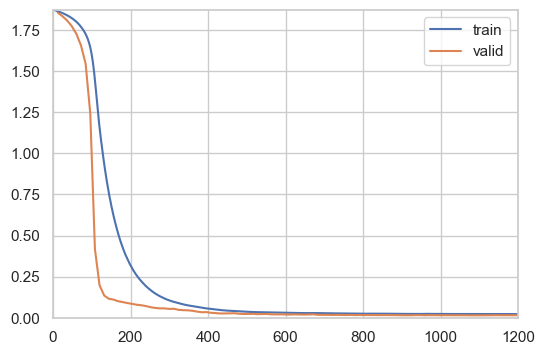

Better model found at epoch 1 with valid_loss value: 1.8339921236038208.
Better model found at epoch 2 with valid_loss value: 1.807977557182312.
Better model found at epoch 3 with valid_loss value: 1.7741059064865112.
Better model found at epoch 4 with valid_loss value: 1.7267924547195435.
Better model found at epoch 5 with valid_loss value: 1.6564422845840454.
Better model found at epoch 6 with valid_loss value: 1.5447672605514526.
Better model found at epoch 7 with valid_loss value: 1.2429550886154175.
Better model found at epoch 8 with valid_loss value: 0.41850337386131287.
Better model found at epoch 9 with valid_loss value: 0.1974387764930725.
Better model found at epoch 10 with valid_loss value: 0.1351957768201828.
Better model found at epoch 11 with valid_loss value: 0.11578507721424103.
Better model found at epoch 12 with valid_loss value: 0.11075115203857422.
Better model found at epoch 13 with valid_loss value: 0.10083432495594025.
Better model found at epoch 14 with valid_lo

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.723660,1.717285,0.060148,0.012030,0.200000,0.022694,00:28
1,1.716511,1.703510,0.060148,0.012030,0.200000,0.022694,00:05
2,1.707720,1.685788,0.060148,0.012030,0.200000,0.022694,00:05
3,1.696387,1.661976,0.060148,0.012030,0.200000,0.022694,00:05
4,1.681327,1.628809,0.060148,0.012030,0.200000,0.022694,00:05
5,1.660647,1.581011,0.060148,0.012030,0.200000,0.022694,00:05
6,1.631831,1.514883,0.060148,0.012043,0.200000,0.022718,00:05
7,1.592229,1.424379,0.060148,0.012090,0.200000,0.022801,00:05
8,1.539635,1.312364,0.110517,0.026158,0.202062,0.045074,00:05
9,1.469138,1.156320,0.110148,0.022030,0.200000,0.039688,00:05


Better model found at epoch 0 with valid_loss value: 1.717285394668579.


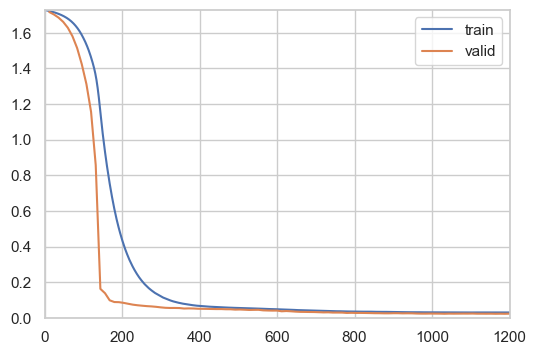

Better model found at epoch 1 with valid_loss value: 1.7035101652145386.
Better model found at epoch 2 with valid_loss value: 1.6857881546020508.
Better model found at epoch 3 with valid_loss value: 1.6619758605957031.
Better model found at epoch 4 with valid_loss value: 1.6288089752197266.
Better model found at epoch 5 with valid_loss value: 1.5810110569000244.
Better model found at epoch 6 with valid_loss value: 1.5148828029632568.
Better model found at epoch 7 with valid_loss value: 1.4243794679641724.
Better model found at epoch 8 with valid_loss value: 1.3123644590377808.
Better model found at epoch 9 with valid_loss value: 1.1563198566436768.
Better model found at epoch 10 with valid_loss value: 0.857558012008667.
Better model found at epoch 11 with valid_loss value: 0.16256800293922424.
Better model found at epoch 12 with valid_loss value: 0.13807469606399536.
Better model found at epoch 13 with valid_loss value: 0.09830563515424728.
Better model found at epoch 14 with valid_los

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.863658,1.851985,0.059963,0.011993,0.200000,0.022628,00:28
1,1.850361,1.826010,0.059963,0.011993,0.200000,0.022628,00:05
2,1.834096,1.793843,0.059963,0.011993,0.200000,0.022628,00:05
3,1.813424,1.750866,0.059963,0.011993,0.200000,0.022628,00:05
4,1.785862,1.689239,0.059963,0.011993,0.200000,0.022628,00:05
5,1.747667,1.598537,0.059963,0.011993,0.200000,0.022628,00:05
6,1.691796,1.452211,0.059963,0.012001,0.200000,0.022644,00:05
7,1.598851,1.142998,0.110148,0.022046,0.200000,0.039714,00:05
8,1.408182,0.351639,0.110148,0.022030,0.200000,0.039688,00:05
9,1.120223,0.177902,0.110148,0.022030,0.200000,0.039688,00:05


Better model found at epoch 0 with valid_loss value: 1.851984977722168.


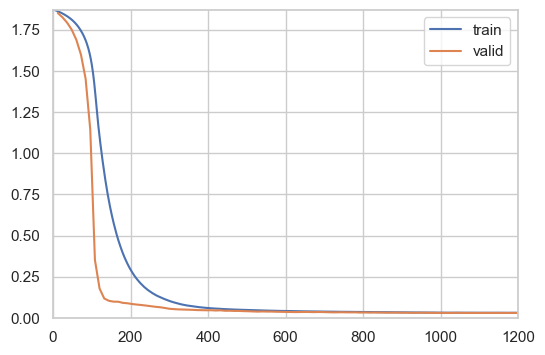

Better model found at epoch 1 with valid_loss value: 1.8260104656219482.
Better model found at epoch 2 with valid_loss value: 1.7938430309295654.
Better model found at epoch 3 with valid_loss value: 1.7508656978607178.
Better model found at epoch 4 with valid_loss value: 1.6892390251159668.
Better model found at epoch 5 with valid_loss value: 1.5985373258590698.
Better model found at epoch 6 with valid_loss value: 1.452210545539856.
Better model found at epoch 7 with valid_loss value: 1.1429979801177979.
Better model found at epoch 8 with valid_loss value: 0.35163944959640503.
Better model found at epoch 9 with valid_loss value: 0.1779024600982666.
Better model found at epoch 10 with valid_loss value: 0.11749069392681122.
Better model found at epoch 11 with valid_loss value: 0.10321060568094254.
Better model found at epoch 12 with valid_loss value: 0.09812982380390167.
Better model found at epoch 13 with valid_loss value: 0.0978873148560524.
Better model found at epoch 14 with valid_lo

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.600777,1.582531,0.000738,0.000148,0.200000,0.000295,00:29
1,1.580077,1.542182,0.000738,0.000148,0.200000,0.000295,00:05
2,1.554829,1.492346,0.000738,0.000148,0.200000,0.000296,00:05
3,1.522887,1.426799,0.109963,0.022546,0.199665,0.040517,00:05
4,1.481058,1.337874,0.110148,0.022070,0.200000,0.039754,00:05
5,1.424601,1.209032,0.110148,0.022030,0.200000,0.039688,00:05
6,1.345053,1.011946,0.110148,0.022030,0.200000,0.039688,00:05
7,1.226162,0.685381,0.110148,0.022030,0.200000,0.039688,00:05
8,1.025386,0.108102,0.110148,0.022030,0.200000,0.039688,00:05
9,0.820297,0.133180,0.110148,0.022030,0.200000,0.039688,00:05


Better model found at epoch 0 with valid_loss value: 1.582531452178955.


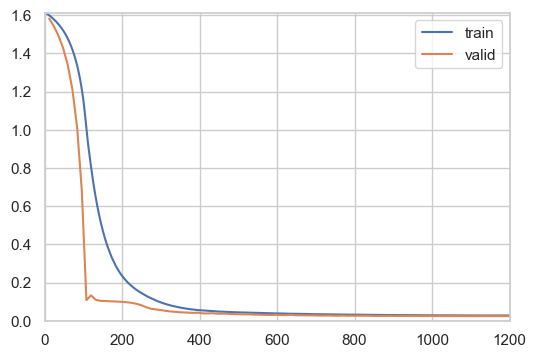

Better model found at epoch 1 with valid_loss value: 1.5421816110610962.
Better model found at epoch 2 with valid_loss value: 1.492346167564392.
Better model found at epoch 3 with valid_loss value: 1.4267992973327637.
Better model found at epoch 4 with valid_loss value: 1.3378738164901733.
Better model found at epoch 5 with valid_loss value: 1.2090318202972412.
Better model found at epoch 6 with valid_loss value: 1.0119456052780151.
Better model found at epoch 7 with valid_loss value: 0.6853809356689453.
Better model found at epoch 8 with valid_loss value: 0.10810235142707825.
Better model found at epoch 11 with valid_loss value: 0.10452152043581009.
Better model found at epoch 12 with valid_loss value: 0.10374800860881805.
Better model found at epoch 13 with valid_loss value: 0.10231275856494904.
Better model found at epoch 14 with valid_loss value: 0.10145992040634155.
Better model found at epoch 15 with valid_loss value: 0.10010568797588348.
Better model found at epoch 16 with valid

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.494846,1.488518,0.000738,0.000148,0.200000,0.000295,00:28
1,1.488095,1.476912,0.000738,0.000148,0.200000,0.000295,00:05
2,1.480888,1.463997,0.000738,0.000148,0.200000,0.000295,00:05
3,1.472275,1.446580,0.000738,0.000148,0.200000,0.000295,00:05
4,1.460935,1.421291,0.000738,0.000148,0.200000,0.000295,00:05
5,1.445009,1.383618,0.000738,0.000148,0.200000,0.000295,00:05
6,1.422069,1.325822,0.110148,0.022030,0.200000,0.039688,00:05
7,1.387355,1.211941,0.110148,0.022030,0.200000,0.039688,00:05
8,1.307848,0.823965,0.110148,0.022030,0.200000,0.039688,00:05
9,1.099041,0.110245,0.110148,0.022030,0.200000,0.039688,00:05


Better model found at epoch 0 with valid_loss value: 1.4885178804397583.


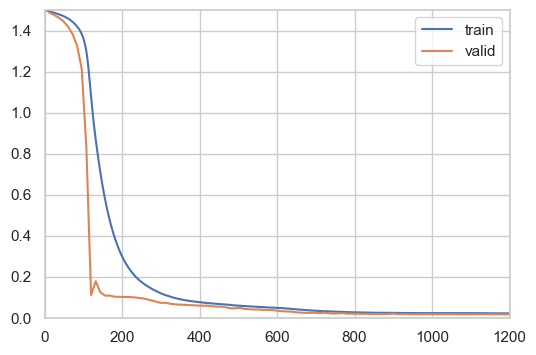

Better model found at epoch 1 with valid_loss value: 1.4769119024276733.
Better model found at epoch 2 with valid_loss value: 1.4639966487884521.
Better model found at epoch 3 with valid_loss value: 1.4465800523757935.
Better model found at epoch 4 with valid_loss value: 1.4212913513183594.
Better model found at epoch 5 with valid_loss value: 1.3836182355880737.
Better model found at epoch 6 with valid_loss value: 1.3258224725723267.
Better model found at epoch 7 with valid_loss value: 1.2119405269622803.
Better model found at epoch 8 with valid_loss value: 0.823964536190033.
Better model found at epoch 9 with valid_loss value: 0.11024471372365952.
Better model found at epoch 12 with valid_loss value: 0.10837256908416748.
Better model found at epoch 14 with valid_loss value: 0.10306975245475769.
Better model found at epoch 15 with valid_loss value: 0.10229302942752838.
Better model found at epoch 16 with valid_loss value: 0.10180366784334183.
Better model found at epoch 17 with valid_l

In [12]:
MODEL_DIR = './models/prototyping2/'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

if os.path.exists(f'{MODEL_DIR}/model.json'):
    with open(f'{MODEL_DIR}/model.json') as f:
        interruptable_info = json.load(f)
else:
    interruptable_info = {
        "fold": 0,
        "epoch": 0
    }
    with open(f'{MODEL_DIR}/model.json', 'x') as f:
        json.dump(interruptable_info, f, indent=4)
learners = []
for idx, (train_index, val_index) in enumerate(skf.split(np.zeros(len(train_ys)), train_ys)):
    if not os.path.exists(f'{MODEL_DIR}/tcn_fold_{idx+1}'):
        os.makedirs(f'{MODEL_DIR}/tcn_fold_{idx+1}')
    tcn_model = TCN(360, 5, [2]*9, 32, 0.125, use_skip_connections=True).cuda()
    if idx < interruptable_info["fold"]:
        continue
    train_fold_set = Subset(train_set, train_index)
    label_counts = {}
    for label in train_ys[train_index]:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1
    total_labels = sum(label_counts.values())
    class_weights = {label: total_labels / count for label, count in label_counts.items()}
    class_weights = torch.tensor(list(class_weights.values()))
    class_weights /= class_weights.max()
    val_fold_set = Subset(train_set, val_index)
    train_fold_loader = DataLoader(train_fold_set, batch_size=4096, shuffle=True, pin_memory=True, num_workers=8, persistent_workers=True)
    val_fold_loader = DataLoader(val_fold_set, batch_size=4096, shuffle=False, pin_memory=True)
    fold_dls = DataLoaders(train_fold_loader, val_fold_loader)
    best_model_cb = SaveModelCallback(monitor="valid_loss", fname=f"best")
    every_epoch_save_cb = SaveModelCallback(monitor="valid_loss", fname=f"epoch", every_epoch=True)
    if not os.path.exists(f"{MODEL_DIR}/tcn_fold_{idx+1}"):
        os.makedirs(f"{MODEL_DIR}/tcn_fold_{idx+1}")
    csv_logger = CSVLogger(fname=f"{MODEL_DIR}/tcn_fold_{idx+1}/log.csv", append=True)
    learn = Learner(
        dls=fold_dls,
        model=tcn_model,
        model_dir=f"{MODEL_DIR}/tcn_fold_{idx+1}/",
        loss_func=nn.CrossEntropyLoss(weight=class_weights.cuda()),
        cbs=[MixedPrecision()],
        metrics=[accuracy, fastai_precision_score(average="macro", zero_division=0.0), Recall(average="macro"), F1Score(average="macro")]
    )
    if interruptable_info["epoch"] != 0 and os.path.exists(f"{MODEL_DIR}/tcn_fold_{idx + 1}/epoch_{interruptable_info['epoch'] + 1}.pth"):
        learn = learn.load(f"{MODEL_DIR}/tcn_fold_{idx + 1}/epoch_{interruptable_info['epoch'] + 1}.pth")
    learn.fit_one_cycle(
        n_epoch=100,
        lr_max=3e-3,
        div=10.0,
        start_epoch=interruptable_info["epoch"],
        wd=3e-4,
        cbs=[LogInterruptable(fn=f"{MODEL_DIR}/model.json"), best_model_cb, every_epoch_save_cb, csv_logger, ShowGraphCallback()],
    )
    train_fold_loader._iterator._shutdown_workers()
    learners.append(learn)
    interruptable_info["epoch"] = 0
    interruptable_info["fold"] += 1
    json.dump(interruptable_info, open(f'{MODEL_DIR}/model.json', 'w'), indent=4)

## Use ImbalancedDatasetSampler to reduce class imbalance

In [13]:
from torch.utils.data import WeightedRandomSampler

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.115650,1.503240,0.110148,0.022030,0.200000,0.039688,00:36
1,1.093428,1.523902,0.110148,0.022030,0.200000,0.039688,00:06
2,1.063623,1.555855,0.110148,0.022030,0.200000,0.039688,00:06
3,1.021964,1.613688,0.110148,0.022030,0.200000,0.039688,00:06
4,0.956532,1.752711,0.110148,0.022030,0.200000,0.039688,00:06
5,0.843218,2.331735,0.110148,0.022030,0.200000,0.039688,00:06
6,0.671808,5.640644,0.110148,0.022030,0.200000,0.039688,00:06
7,0.538307,8.780883,0.110148,0.022030,0.200000,0.039688,00:06
8,0.442395,6.576651,0.110148,0.022030,0.200000,0.039688,00:06
9,0.366300,4.560426,0.110148,0.022030,0.200000,0.039688,00:06


Better model found at epoch 0 with valid_loss value: 1.5032401084899902.


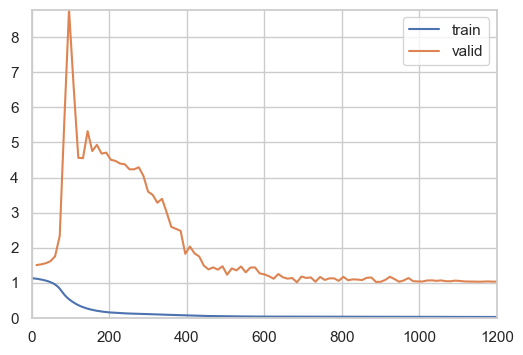

Better model found at epoch 36 with valid_loss value: 1.4864698648452759.
Better model found at epoch 37 with valid_loss value: 1.3791327476501465.
Better model found at epoch 39 with valid_loss value: 1.3719756603240967.
Better model found at epoch 41 with valid_loss value: 1.2284876108169556.
Better model found at epoch 50 with valid_loss value: 1.186530351638794.
Better model found at epoch 51 with valid_loss value: 1.1143826246261597.
Better model found at epoch 56 with valid_loss value: 1.0130366086959839.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.296154,1.437018,0.110148,0.022030,0.200000,0.039688,00:30
1,1.288263,1.441237,0.110148,0.022030,0.200000,0.039688,00:05
2,1.278349,1.447098,0.110148,0.022030,0.200000,0.039688,00:05
3,1.265387,1.455798,0.110148,0.022030,0.200000,0.039688,00:05
4,1.247749,1.469542,0.110148,0.022030,0.200000,0.039688,00:05
5,1.222770,1.492222,0.110148,0.022030,0.200000,0.039688,00:05
6,1.185826,1.533282,0.110148,0.022030,0.200000,0.039688,00:05
7,1.129362,1.617263,0.110148,0.022030,0.200000,0.039688,00:05
8,1.038934,1.825367,0.110148,0.022030,0.200000,0.039688,00:05
9,0.892075,2.702852,0.110148,0.022030,0.200000,0.039688,00:05


Better model found at epoch 0 with valid_loss value: 1.4370183944702148.


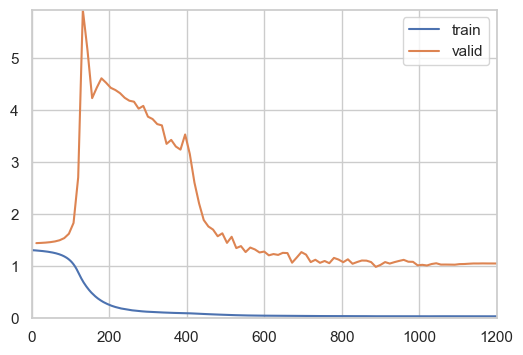

Better model found at epoch 43 with valid_loss value: 1.3416779041290283.
Better model found at epoch 45 with valid_loss value: 1.2652361392974854.
Better model found at epoch 48 with valid_loss value: 1.2570221424102783.
Better model found at epoch 50 with valid_loss value: 1.202461838722229.
Better model found at epoch 55 with valid_loss value: 1.0605944395065308.
Better model found at epoch 61 with valid_loss value: 1.0582195520401.
Better model found at epoch 63 with valid_loss value: 1.0510483980178833.
Better model found at epoch 68 with valid_loss value: 1.0401694774627686.
Better model found at epoch 73 with valid_loss value: 0.9799396395683289.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.214747,1.949658,0.110148,0.022030,0.200000,0.039688,00:39
1,1.197514,1.959261,0.110148,0.022030,0.200000,0.039688,00:06
2,1.177908,1.971910,0.110148,0.022030,0.200000,0.039688,00:06
3,1.154681,1.988412,0.110148,0.022030,0.200000,0.039688,00:05
4,1.126389,2.011291,0.110148,0.022030,0.200000,0.039688,00:05
5,1.091473,2.042894,0.110148,0.022030,0.200000,0.039688,00:05
6,1.048021,2.088810,0.110148,0.022030,0.200000,0.039688,00:06
7,0.994190,2.155859,0.110148,0.022030,0.200000,0.039688,00:05
8,0.928925,2.257884,0.110148,0.022030,0.200000,0.039688,00:05
9,0.849098,2.442045,0.110148,0.022030,0.200000,0.039688,00:06


Better model found at epoch 0 with valid_loss value: 1.9496583938598633.


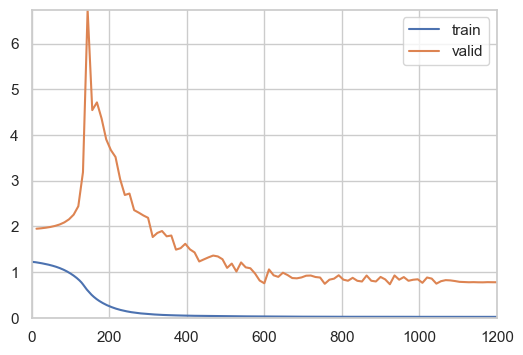

Better model found at epoch 25 with valid_loss value: 1.7683384418487549.
Better model found at epoch 30 with valid_loss value: 1.4921178817749023.
Better model found at epoch 34 with valid_loss value: 1.4308699369430542.
Better model found at epoch 35 with valid_loss value: 1.2326595783233643.
Better model found at epoch 41 with valid_loss value: 1.0926384925842285.
Better model found at epoch 43 with valid_loss value: 1.0129969120025635.
Better model found at epoch 47 with valid_loss value: 0.9698963761329651.
Better model found at epoch 48 with valid_loss value: 0.8151206970214844.
Better model found at epoch 49 with valid_loss value: 0.755581259727478.
Better model found at epoch 62 with valid_loss value: 0.7444160580635071.
Better model found at epoch 76 with valid_loss value: 0.7344530820846558.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.625583,1.963870,0.015314,0.003063,0.200000,0.006033,00:31
1,1.620614,1.965867,0.015314,0.003063,0.200000,0.006033,00:05
2,1.614402,1.968784,0.015314,0.003063,0.200000,0.006033,00:05
3,1.605465,1.973533,0.015314,0.003063,0.200000,0.006033,00:05
4,1.592219,1.981080,0.015314,0.003063,0.200000,0.006033,00:05
5,1.567716,2.000530,0.015314,0.003063,0.200000,0.006033,00:05
6,1.486404,2.181311,0.110148,0.022030,0.200000,0.039688,00:05
7,1.213187,7.324730,0.110148,0.022030,0.200000,0.039688,00:05
8,0.981849,12.985675,0.110148,0.022030,0.200000,0.039688,00:05
9,0.806173,8.238467,0.110148,0.022030,0.200000,0.039688,00:05


Better model found at epoch 0 with valid_loss value: 1.9638699293136597.


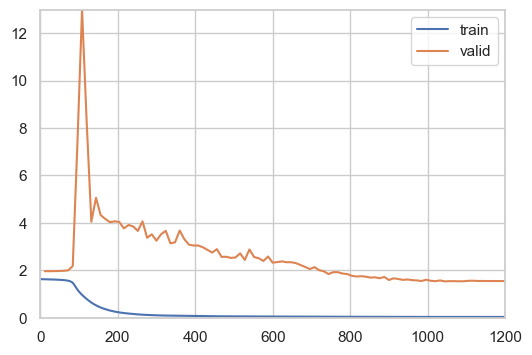

Better model found at epoch 60 with valid_loss value: 1.959608554840088.
Better model found at epoch 61 with valid_loss value: 1.8452000617980957.
Better model found at epoch 66 with valid_loss value: 1.7709524631500244.
Better model found at epoch 67 with valid_loss value: 1.7435498237609863.
Better model found at epoch 69 with valid_loss value: 1.734607458114624.
Better model found at epoch 70 with valid_loss value: 1.6956299543380737.
Better model found at epoch 72 with valid_loss value: 1.6689395904541016.
Better model found at epoch 74 with valid_loss value: 1.5935615301132202.
Better model found at epoch 79 with valid_loss value: 1.5886248350143433.
Better model found at epoch 80 with valid_loss value: 1.5764331817626953.
Better model found at epoch 81 with valid_loss value: 1.5523285865783691.
Better model found at epoch 84 with valid_loss value: 1.5435609817504883.
Better model found at epoch 86 with valid_loss value: 1.5354621410369873.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,2.145732,1.083495,0.813838,0.162768,0.200000,0.179473,00:29
1,2.135187,1.083786,0.813838,0.162768,0.200000,0.179473,00:05
2,2.123952,1.084074,0.813838,0.162768,0.200000,0.179473,00:05
3,2.110546,1.084192,0.813838,0.162768,0.200000,0.179473,00:05
4,2.094456,1.083723,0.813838,0.162768,0.200000,0.179473,00:05
5,2.073994,1.083009,0.813838,0.162768,0.200000,0.179473,00:05
6,2.044595,1.083361,0.813838,0.162768,0.200000,0.179473,00:05
7,2.002701,1.086265,0.813838,0.162768,0.200000,0.179473,00:05
8,1.943030,1.094661,0.813838,0.162768,0.200000,0.179473,00:05
9,1.858697,1.116374,0.813838,0.162768,0.200000,0.179473,00:05


Better model found at epoch 0 with valid_loss value: 1.0834949016571045.


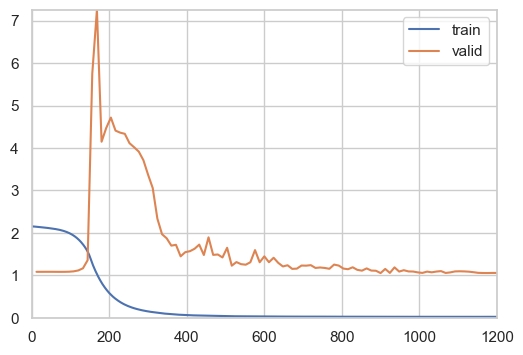

Better model found at epoch 5 with valid_loss value: 1.0830094814300537.
Better model found at epoch 74 with valid_loss value: 1.054093599319458.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.988804,2.083939,0.000554,0.000111,0.200000,0.000221,00:28
1,1.979770,2.084049,0.000554,0.000111,0.200000,0.000221,00:05
2,1.968681,2.082439,0.000554,0.000111,0.200000,0.000221,00:05
3,1.954482,2.080549,0.000554,0.000111,0.200000,0.000221,00:05
4,1.935296,2.078290,0.000554,0.000111,0.200000,0.000221,00:05
5,1.909704,2.075738,0.000554,0.000111,0.200000,0.000221,00:05
6,1.871894,2.071565,0.000554,0.000111,0.200000,0.000221,00:05
7,1.809438,2.068902,0.000554,0.000111,0.200000,0.000221,00:05
8,1.661294,2.235630,0.110148,0.022030,0.200000,0.039688,00:05
9,1.335531,11.739770,0.110148,0.022030,0.200000,0.039688,00:05


Better model found at epoch 0 with valid_loss value: 2.08393931388855.


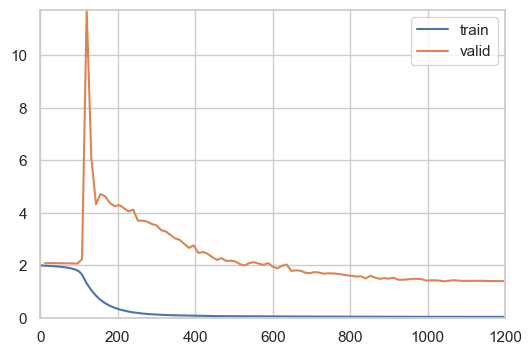

Better model found at epoch 2 with valid_loss value: 2.082439422607422.
Better model found at epoch 3 with valid_loss value: 2.0805487632751465.
Better model found at epoch 4 with valid_loss value: 2.0782902240753174.
Better model found at epoch 5 with valid_loss value: 2.0757384300231934.
Better model found at epoch 6 with valid_loss value: 2.0715653896331787.
Better model found at epoch 7 with valid_loss value: 2.068901538848877.
Better model found at epoch 42 with valid_loss value: 2.04252290725708.
Better model found at epoch 43 with valid_loss value: 1.9957427978515625.
Better model found at epoch 49 with valid_loss value: 1.9507850408554077.
Better model found at epoch 50 with valid_loss value: 1.8840670585632324.
Better model found at epoch 53 with valid_loss value: 1.7899713516235352.
Better model found at epoch 56 with valid_loss value: 1.7189124822616577.
Better model found at epoch 57 with valid_loss value: 1.7016510963439941.
Better model found at epoch 60 with valid_loss v

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,2.049322,1.462103,0.015314,0.003063,0.200000,0.006033,00:29
1,2.040953,1.464052,0.015314,0.003063,0.200000,0.006033,00:05
2,2.030740,1.466399,0.015314,0.003063,0.200000,0.006033,00:05
3,2.017627,1.468783,0.015314,0.003063,0.200000,0.006033,00:05
4,1.999628,1.472904,0.015314,0.003063,0.200000,0.006033,00:05
5,1.971230,1.481965,0.015314,0.003063,0.200000,0.006033,00:05
6,1.920001,1.508705,0.015314,0.003063,0.200000,0.006033,00:05
7,1.800320,1.675250,0.110148,0.022030,0.200000,0.039688,00:05
8,1.504796,4.468211,0.110148,0.022030,0.200000,0.039688,00:05
9,1.191202,10.629943,0.110148,0.022030,0.200000,0.039688,00:05


Better model found at epoch 0 with valid_loss value: 1.4621026515960693.


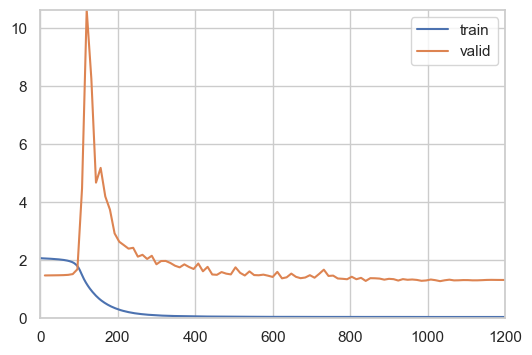

Better model found at epoch 43 with valid_loss value: 1.460437297821045.
Better model found at epoch 48 with valid_loss value: 1.4536011219024658.
Better model found at epoch 49 with valid_loss value: 1.4103176593780518.
Better model found at epoch 51 with valid_loss value: 1.3621735572814941.
Better model found at epoch 63 with valid_loss value: 1.3571393489837646.
Better model found at epoch 64 with valid_loss value: 1.3464750051498413.
Better model found at epoch 65 with valid_loss value: 1.3311039209365845.
Better model found at epoch 69 with valid_loss value: 1.2728967666625977.
Better model found at epoch 85 with valid_loss value: 1.2647615671157837.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.366253,2.217964,0.015314,0.003063,0.200000,0.006033,00:29
1,1.356215,2.220983,0.015314,0.003063,0.200000,0.006033,00:05
2,1.344476,2.225885,0.015314,0.003063,0.200000,0.006033,00:05
3,1.330762,2.233329,0.015314,0.003063,0.200000,0.006033,00:05
4,1.313875,2.243541,0.015314,0.003063,0.200000,0.006033,00:05
5,1.291109,2.260375,0.110148,0.022103,0.200000,0.039807,00:05
6,1.258723,2.291337,0.110148,0.022030,0.200000,0.039688,00:05
7,1.208350,2.353452,0.110148,0.022030,0.200000,0.039688,00:05
8,1.117565,2.615325,0.110148,0.022030,0.200000,0.039688,00:05
9,0.927532,6.793971,0.110148,0.022030,0.200000,0.039688,00:05


Better model found at epoch 0 with valid_loss value: 2.2179641723632812.


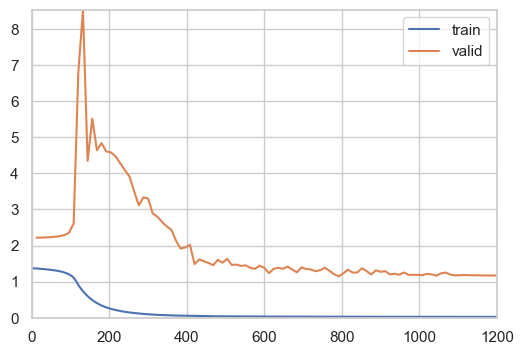

Better model found at epoch 30 with valid_loss value: 2.1364645957946777.
Better model found at epoch 31 with valid_loss value: 1.9158285856246948.
Better model found at epoch 34 with valid_loss value: 1.486095905303955.
Better model found at epoch 38 with valid_loss value: 1.45755934715271.
Better model found at epoch 44 with valid_loss value: 1.4361393451690674.
Better model found at epoch 46 with valid_loss value: 1.3805105686187744.
Better model found at epoch 47 with valid_loss value: 1.3564739227294922.
Better model found at epoch 50 with valid_loss value: 1.2359269857406616.
Better model found at epoch 64 with valid_loss value: 1.2080780267715454.
Better model found at epoch 65 with valid_loss value: 1.1493632793426514.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,2.090577,1.698448,0.000738,0.000148,0.200000,0.000295,00:29
1,2.062670,1.700592,0.000738,0.000148,0.200000,0.000295,00:05
2,2.030369,1.703406,0.000738,0.000148,0.200000,0.000295,00:05
3,1.991102,1.707377,0.000738,0.000148,0.200000,0.000295,00:05
4,1.940310,1.715309,0.000738,0.000148,0.200000,0.000295,00:05
5,1.865854,1.735755,0.000738,0.000149,0.200000,0.000297,00:05
6,1.726923,1.916070,0.110148,0.022030,0.200000,0.039688,00:05
7,1.403230,5.828306,0.110148,0.022030,0.200000,0.039688,00:05
8,1.109450,11.920408,0.110148,0.022030,0.200000,0.039688,00:05
9,0.893782,8.053591,0.110148,0.022030,0.200000,0.039688,00:05


Better model found at epoch 0 with valid_loss value: 1.698447585105896.


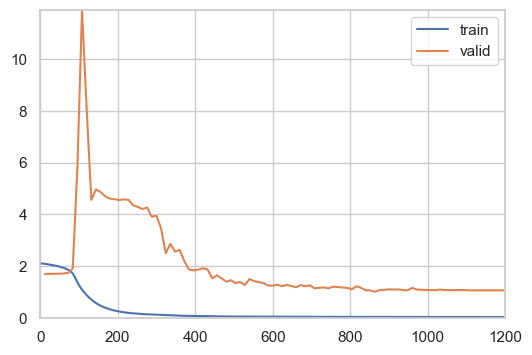

Better model found at epoch 36 with valid_loss value: 1.5278401374816895.
Better model found at epoch 39 with valid_loss value: 1.39524507522583.
Better model found at epoch 41 with valid_loss value: 1.3425536155700684.
Better model found at epoch 43 with valid_loss value: 1.267073631286621.
Better model found at epoch 48 with valid_loss value: 1.2536860704421997.
Better model found at epoch 49 with valid_loss value: 1.2417418956756592.
Better model found at epoch 51 with valid_loss value: 1.2218899726867676.
Better model found at epoch 54 with valid_loss value: 1.1800775527954102.
Better model found at epoch 58 with valid_loss value: 1.142115831375122.
Better model found at epoch 61 with valid_loss value: 1.1417031288146973.
Better model found at epoch 66 with valid_loss value: 1.1021087169647217.
Better model found at epoch 69 with valid_loss value: 1.0670139789581299.
Better model found at epoch 70 with valid_loss value: 1.0576092004776.
Better model found at epoch 71 with valid_los

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.316176,1.673567,0.110148,0.022030,0.200000,0.039688,00:30
1,1.299720,1.683164,0.110148,0.022030,0.200000,0.039688,00:05
2,1.279623,1.696273,0.110148,0.022030,0.200000,0.039688,00:05
3,1.252639,1.717964,0.110148,0.022030,0.200000,0.039688,00:05
4,1.211671,1.767909,0.110148,0.022030,0.200000,0.039688,00:05
5,1.141869,1.876600,0.110148,0.022030,0.200000,0.039688,00:05
6,1.028531,2.132068,0.110148,0.022030,0.200000,0.039688,00:05
7,0.867775,2.763288,0.110148,0.022046,0.200000,0.039714,00:05
8,0.690939,6.028360,0.110148,0.022042,0.200000,0.039707,00:05
9,0.552507,4.471107,0.110148,0.022038,0.200000,0.039701,00:05


Better model found at epoch 0 with valid_loss value: 1.6735674142837524.


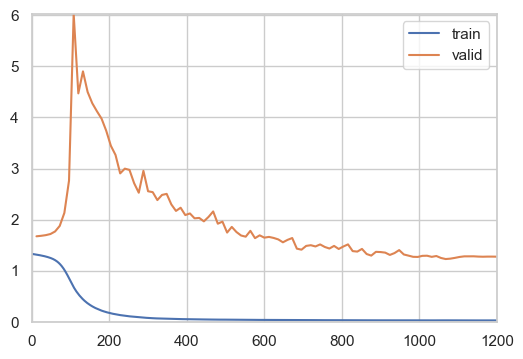

Better model found at epoch 45 with valid_loss value: 1.6660711765289307.
Better model found at epoch 47 with valid_loss value: 1.637460708618164.
Better model found at epoch 52 with valid_loss value: 1.612713098526001.
Better model found at epoch 53 with valid_loss value: 1.556081771850586.
Better model found at epoch 56 with valid_loss value: 1.4317798614501953.
Better model found at epoch 57 with valid_loss value: 1.4117517471313477.
Better model found at epoch 68 with valid_loss value: 1.383649468421936.
Better model found at epoch 69 with valid_loss value: 1.3742202520370483.
Better model found at epoch 71 with valid_loss value: 1.3268873691558838.
Better model found at epoch 72 with valid_loss value: 1.2956820726394653.
Better model found at epoch 80 with valid_loss value: 1.2952605485916138.
Better model found at epoch 81 with valid_loss value: 1.2718778848648071.
Better model found at epoch 82 with valid_loss value: 1.2696284055709839.
Better model found at epoch 87 with valid_

In [15]:
MODEL_DIR = './models/prototyping3/'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

if os.path.exists(f'{MODEL_DIR}/model.json'):
    with open(f'{MODEL_DIR}/model.json') as f:
        interruptable_info = json.load(f)
else:
    interruptable_info = {
        "fold": 0,
        "epoch": 0
    }
    with open(f'{MODEL_DIR}/model.json', 'x') as f:
        json.dump(interruptable_info, f, indent=4)
learners = []
for idx, (train_index, val_index) in enumerate(skf.split(np.zeros(len(train_ys)), train_ys)):
    if not os.path.exists(f'{MODEL_DIR}/tcn_fold_{idx+1}'):
        os.makedirs(f'{MODEL_DIR}/tcn_fold_{idx+1}')
    tcn_model = TCN(360, 5, [2]*9, 32, 0.125, use_skip_connections=True).cuda()
    if idx < interruptable_info["fold"]:
        continue
    train_fold_set = Subset(train_set, train_index)
    label_counts = {}
    for label in train_ys[train_index]:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1
    total_labels = sum(label_counts.values())
    class_weights = {label: total_labels / count for label, count in label_counts.items()}
    class_weights = torch.tensor(list(class_weights.values()))
    class_weights /= class_weights.max()
    val_fold_set = Subset(train_set, val_index)
    # sampler = ImbalancedDatasetSampler(
    #     dataset=train_set,
    #     indices=train_index,
    #     callback_get_label=lambda dataset: dataset.y,
    #     labels=train_ys[train_index]
    # )
    sampler = WeightedRandomSampler(
        weights=[class_weights[label_encode(label)] for label in train_ys[train_index]],
        num_samples=len(train_index),
        replacement=True
    )
    train_fold_loader = DataLoader(train_fold_set, batch_size=4096, pin_memory=True, num_workers=8, persistent_workers=True, sampler=sampler)
    val_fold_loader = DataLoader(val_fold_set, batch_size=4096, shuffle=False, pin_memory=True)
    fold_dls = DataLoaders(train_fold_loader, val_fold_loader)
    best_model_cb = SaveModelCallback(monitor="valid_loss", fname=f"best")
    every_epoch_save_cb = SaveModelCallback(monitor="valid_loss", fname=f"epoch", every_epoch=True)
    if not os.path.exists(f"{MODEL_DIR}/tcn_fold_{idx+1}"):
        os.makedirs(f"{MODEL_DIR}/tcn_fold_{idx+1}")
    csv_logger = CSVLogger(fname=f"{MODEL_DIR}/tcn_fold_{idx+1}/log.csv", append=True)
    learn = Learner(
        dls=fold_dls,
        model=tcn_model,
        model_dir=f"{MODEL_DIR}/tcn_fold_{idx+1}/",
        loss_func=nn.CrossEntropyLoss(),
        cbs=[MixedPrecision()],
        metrics=[accuracy, fastai_precision_score(average="macro", zero_division=0.0), Recall(average="macro"), F1Score(average="macro")]
    )
    if interruptable_info["epoch"] != 0 and os.path.exists(f"{MODEL_DIR}/tcn_fold_{idx + 1}/epoch_{interruptable_info['epoch'] + 1}.pth"):
        learn = learn.load(f"{MODEL_DIR}/tcn_fold_{idx + 1}/epoch_{interruptable_info['epoch'] + 1}.pth")
    learn.fit_one_cycle(
        n_epoch=100,
        lr_max=3e-3,
        div=10.0,
        start_epoch=interruptable_info["epoch"],
        wd=3e-4,
        cbs=[LogInterruptable(fn=f"{MODEL_DIR}/model.json"), best_model_cb, every_epoch_save_cb, csv_logger, ShowGraphCallback()],
    )
    train_fold_loader._iterator._shutdown_workers()
    learners.append(learn)
    interruptable_info["epoch"] = 0
    interruptable_info["fold"] += 1
    json.dump(interruptable_info, open(f'{MODEL_DIR}/model.json', 'w'), indent=4)

## Ignore the dataset imbalance?

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.272907,1.249626,0.813838,0.162768,0.200000,0.179473,00:31
1,1.246127,1.174631,0.813838,0.162768,0.200000,0.179473,00:06
2,1.192744,1.019872,0.813838,0.162768,0.200000,0.179473,00:06
3,1.092902,0.772988,0.813838,0.162768,0.200000,0.179473,00:06
4,1.004278,0.714884,0.813838,0.162768,0.200000,0.179473,00:06
5,0.934813,0.648400,0.813838,0.162768,0.200000,0.179473,00:06
6,0.879595,0.640551,0.813838,0.162768,0.200000,0.179473,00:06
7,0.835489,0.626921,0.813838,0.162768,0.200000,0.179473,00:06
8,0.797911,0.578989,0.813838,0.162768,0.200000,0.179473,00:06
9,0.762298,0.526997,0.813838,0.162768,0.200000,0.179473,00:06


Better model found at epoch 0 with valid_loss value: 1.2496256828308105.


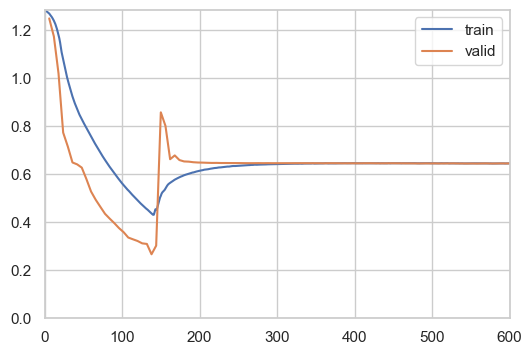

Better model found at epoch 1 with valid_loss value: 1.1746307611465454.
Better model found at epoch 2 with valid_loss value: 1.0198724269866943.
Better model found at epoch 3 with valid_loss value: 0.7729878425598145.
Better model found at epoch 4 with valid_loss value: 0.7148837447166443.
Better model found at epoch 5 with valid_loss value: 0.6483995914459229.
Better model found at epoch 6 with valid_loss value: 0.6405506134033203.
Better model found at epoch 7 with valid_loss value: 0.6269205808639526.
Better model found at epoch 8 with valid_loss value: 0.5789890289306641.
Better model found at epoch 9 with valid_loss value: 0.5269971489906311.
Better model found at epoch 10 with valid_loss value: 0.4926466941833496.
Better model found at epoch 11 with valid_loss value: 0.46313774585723877.
Better model found at epoch 12 with valid_loss value: 0.4340650141239166.
Better model found at epoch 13 with valid_loss value: 0.41410577297210693.
Better model found at epoch 14 with valid_los

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.836619,1.761033,0.060148,0.012030,0.200000,0.022694,00:29
1,1.758016,1.583871,0.060148,0.012030,0.200000,0.022694,00:06
2,1.659070,1.361734,0.811070,0.162724,0.199320,0.179173,00:06
3,1.535824,1.070040,0.813838,0.162768,0.200000,0.179473,00:06
4,1.382849,0.745393,0.813838,0.162768,0.200000,0.179473,00:06
5,1.246360,0.772831,0.813838,0.162768,0.200000,0.179473,00:06
6,1.143586,0.664733,0.813838,0.162768,0.200000,0.179473,00:06
7,1.055581,0.646615,0.813838,0.162768,0.200000,0.179473,00:06
8,0.982782,0.597292,0.813469,0.162754,0.199909,0.179428,00:06
9,0.918215,0.541243,0.813284,0.362770,0.200432,0.180625,00:06


Better model found at epoch 0 with valid_loss value: 1.7610325813293457.


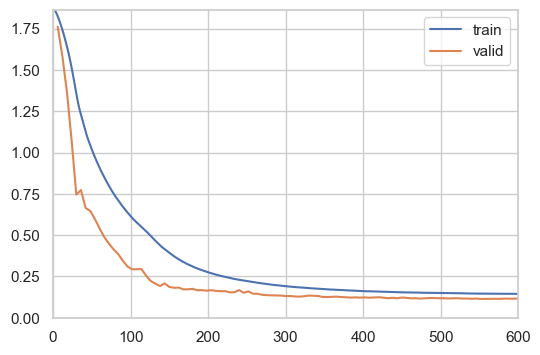

Better model found at epoch 1 with valid_loss value: 1.5838710069656372.
Better model found at epoch 2 with valid_loss value: 1.36173415184021.
Better model found at epoch 3 with valid_loss value: 1.0700403451919556.
Better model found at epoch 4 with valid_loss value: 0.7453934550285339.
Better model found at epoch 6 with valid_loss value: 0.6647328734397888.
Better model found at epoch 7 with valid_loss value: 0.646615207195282.
Better model found at epoch 8 with valid_loss value: 0.5972917079925537.
Better model found at epoch 9 with valid_loss value: 0.5412425994873047.
Better model found at epoch 10 with valid_loss value: 0.48874011635780334.
Better model found at epoch 11 with valid_loss value: 0.4490407407283783.
Better model found at epoch 12 with valid_loss value: 0.4145984947681427.
Better model found at epoch 13 with valid_loss value: 0.3858364224433899.
Better model found at epoch 14 with valid_loss value: 0.3451290726661682.
Better model found at epoch 15 with valid_loss v

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.480344,1.442017,0.015314,0.003063,0.200000,0.006033,00:29
1,1.442314,1.355972,0.813838,0.162768,0.200000,0.179473,00:06
2,1.393647,1.213981,0.813838,0.162768,0.200000,0.179473,00:06
3,1.295628,0.868103,0.813838,0.162768,0.200000,0.179473,00:06
4,1.194822,0.762824,0.813838,0.162768,0.200000,0.179473,00:06
5,1.091182,0.668579,0.813838,0.162768,0.200000,0.179473,00:06
6,1.007563,0.659556,0.813838,0.162768,0.200000,0.179473,00:06
7,0.944364,0.656219,0.813838,0.162768,0.200000,0.179473,00:06
8,0.895783,0.652595,0.813838,0.162768,0.200000,0.179473,00:06
9,0.857073,0.647500,0.813838,0.162768,0.200000,0.179473,00:06


Better model found at epoch 0 with valid_loss value: 1.4420167207717896.


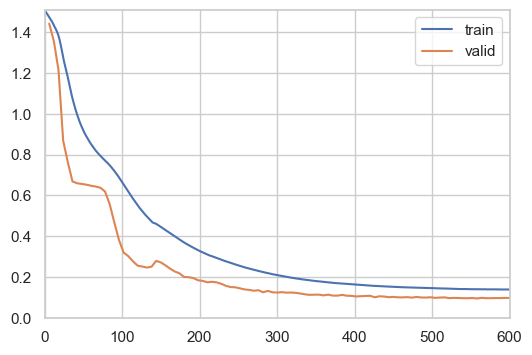

Better model found at epoch 1 with valid_loss value: 1.3559722900390625.
Better model found at epoch 2 with valid_loss value: 1.2139809131622314.
Better model found at epoch 3 with valid_loss value: 0.8681027293205261.
Better model found at epoch 4 with valid_loss value: 0.762824296951294.
Better model found at epoch 5 with valid_loss value: 0.6685787439346313.
Better model found at epoch 6 with valid_loss value: 0.6595561504364014.
Better model found at epoch 7 with valid_loss value: 0.656219482421875.
Better model found at epoch 8 with valid_loss value: 0.6525954008102417.
Better model found at epoch 9 with valid_loss value: 0.6474997997283936.
Better model found at epoch 10 with valid_loss value: 0.6435152292251587.
Better model found at epoch 11 with valid_loss value: 0.6376403570175171.
Better model found at epoch 12 with valid_loss value: 0.6191413402557373.
Better model found at epoch 13 with valid_loss value: 0.557474672794342.
Better model found at epoch 14 with valid_loss val

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.555016,1.519756,0.110517,0.222038,0.200091,0.039882,00:33
1,1.518646,1.436316,0.813838,0.162768,0.200000,0.179473,00:07
2,1.471269,1.304805,0.813838,0.162768,0.200000,0.179473,00:07
3,1.366924,0.772472,0.813838,0.162768,0.200000,0.179473,00:07
4,1.233577,0.734627,0.813838,0.162768,0.200000,0.179473,00:07
5,1.121356,0.734941,0.813838,0.162768,0.200000,0.179473,00:07
6,1.037253,0.666445,0.813838,0.162768,0.200000,0.179473,00:06
7,0.969643,0.667505,0.813838,0.162768,0.200000,0.179473,00:06
8,0.915529,0.637619,0.813838,0.162768,0.200000,0.179473,00:06
9,0.871587,0.635485,0.813838,0.162768,0.200000,0.179473,00:06


Better model found at epoch 0 with valid_loss value: 1.5197559595108032.


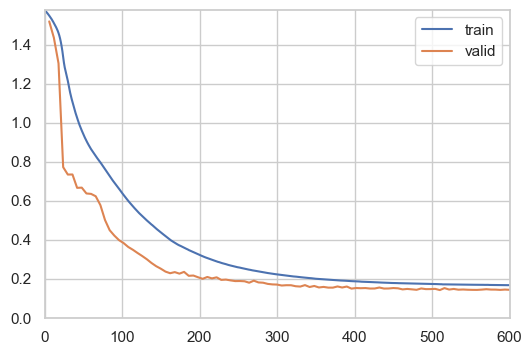

Better model found at epoch 1 with valid_loss value: 1.4363163709640503.
Better model found at epoch 2 with valid_loss value: 1.3048049211502075.
Better model found at epoch 3 with valid_loss value: 0.7724724411964417.
Better model found at epoch 4 with valid_loss value: 0.7346268892288208.
Better model found at epoch 6 with valid_loss value: 0.6664448976516724.
Better model found at epoch 8 with valid_loss value: 0.6376194357872009.
Better model found at epoch 9 with valid_loss value: 0.6354846954345703.
Better model found at epoch 10 with valid_loss value: 0.6232861876487732.
Better model found at epoch 11 with valid_loss value: 0.5781202912330627.
Better model found at epoch 12 with valid_loss value: 0.5012910962104797.
Better model found at epoch 13 with valid_loss value: 0.449215292930603.
Better model found at epoch 14 with valid_loss value: 0.42165395617485046.
Better model found at epoch 15 with valid_loss value: 0.3984408378601074.
Better model found at epoch 16 with valid_los

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.691662,1.637832,0.015314,0.003063,0.200000,0.006033,00:29
1,1.628693,1.436774,0.813469,0.162754,0.199909,0.179428,00:06
2,1.498019,0.955627,0.813838,0.162768,0.200000,0.179473,00:06
3,1.302764,0.842851,0.813838,0.162768,0.200000,0.179473,00:06
4,1.186760,0.709262,0.813838,0.162768,0.200000,0.179473,00:06
5,1.081281,0.677851,0.813838,0.162768,0.200000,0.179473,00:06
6,1.008774,0.687084,0.813838,0.162768,0.200000,0.179473,00:06
7,0.951964,0.646220,0.813838,0.162768,0.200000,0.179473,00:06
8,0.905617,0.642219,0.813838,0.162768,0.200000,0.179473,00:06
9,0.865325,0.634684,0.813838,0.162768,0.200000,0.179473,00:06


Better model found at epoch 0 with valid_loss value: 1.6378322839736938.


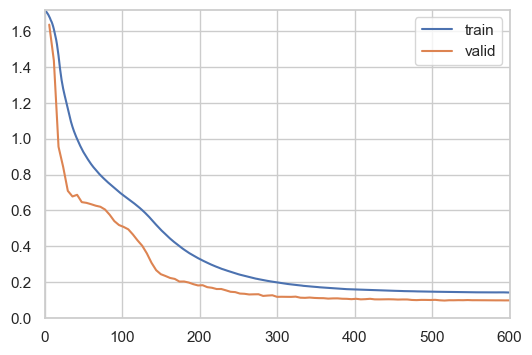

Better model found at epoch 1 with valid_loss value: 1.4367737770080566.
Better model found at epoch 2 with valid_loss value: 0.9556267857551575.
Better model found at epoch 3 with valid_loss value: 0.842851459980011.
Better model found at epoch 4 with valid_loss value: 0.709261953830719.
Better model found at epoch 5 with valid_loss value: 0.6778514385223389.
Better model found at epoch 7 with valid_loss value: 0.6462202668190002.
Better model found at epoch 8 with valid_loss value: 0.6422190070152283.
Better model found at epoch 9 with valid_loss value: 0.6346843838691711.
Better model found at epoch 10 with valid_loss value: 0.626293420791626.
Better model found at epoch 11 with valid_loss value: 0.6203394532203674.
Better model found at epoch 12 with valid_loss value: 0.6049872040748596.
Better model found at epoch 13 with valid_loss value: 0.5757729411125183.
Better model found at epoch 14 with valid_loss value: 0.5402315855026245.
Better model found at epoch 15 with valid_loss va

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.675172,1.619601,0.059963,0.011993,0.200000,0.022628,00:29
1,1.621876,1.521360,0.066421,0.174879,0.201587,0.025943,00:06
2,1.559161,1.344464,0.795572,0.164078,0.196126,0.178182,00:06
3,1.458937,1.028891,0.812731,0.162696,0.199773,0.179338,00:06
4,1.312681,0.754865,0.813653,0.162731,0.200000,0.179451,00:06
5,1.195691,0.721053,0.813653,0.162731,0.200000,0.179451,00:06
6,1.099885,0.672325,0.813653,0.162731,0.200000,0.179451,00:06
7,1.023117,0.663415,0.813653,0.162731,0.200000,0.179451,00:06
8,0.961958,0.653178,0.813653,0.162731,0.200000,0.179451,00:06
9,0.911763,0.641492,0.813653,0.162731,0.200000,0.179451,00:06


Better model found at epoch 0 with valid_loss value: 1.6196011304855347.


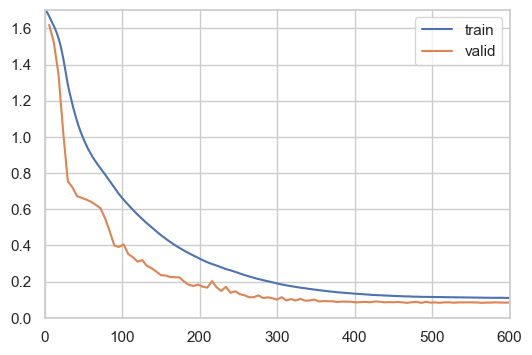

Better model found at epoch 1 with valid_loss value: 1.5213596820831299.
Better model found at epoch 2 with valid_loss value: 1.3444641828536987.
Better model found at epoch 3 with valid_loss value: 1.0288914442062378.
Better model found at epoch 4 with valid_loss value: 0.7548646926879883.
Better model found at epoch 5 with valid_loss value: 0.7210530042648315.
Better model found at epoch 6 with valid_loss value: 0.6723245978355408.
Better model found at epoch 7 with valid_loss value: 0.663415253162384.
Better model found at epoch 8 with valid_loss value: 0.653178334236145.
Better model found at epoch 9 with valid_loss value: 0.6414923667907715.
Better model found at epoch 10 with valid_loss value: 0.6245496273040771.
Better model found at epoch 11 with valid_loss value: 0.6065070033073425.
Better model found at epoch 12 with valid_loss value: 0.5508292317390442.
Better model found at epoch 13 with valid_loss value: 0.47916290163993835.
Better model found at epoch 14 with valid_loss v

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.422776,1.387082,0.811808,0.179352,0.201882,0.183389,00:29
1,1.385888,1.303418,0.811808,0.179352,0.201882,0.183389,00:06
2,1.336958,1.184658,0.812177,0.182699,0.201973,0.183522,00:06
3,1.277294,1.051023,0.813100,0.202733,0.202200,0.183874,00:06
4,1.201205,0.873073,0.813100,0.162710,0.199864,0.179383,00:06
5,1.114775,0.745577,0.813653,0.162731,0.200000,0.179451,00:06
6,1.038458,0.735218,0.813653,0.162731,0.200000,0.179451,00:06
7,0.983608,0.733055,0.813653,0.162731,0.200000,0.179451,00:06
8,0.935997,0.674193,0.813653,0.162731,0.200000,0.179451,00:06
9,0.892028,0.666270,0.813653,0.162731,0.200000,0.179451,00:06


Better model found at epoch 0 with valid_loss value: 1.3870823383331299.


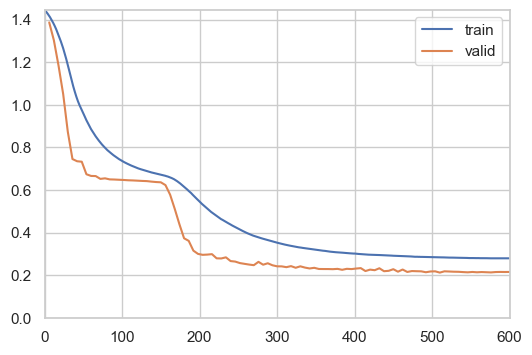

Better model found at epoch 1 with valid_loss value: 1.303417682647705.
Better model found at epoch 2 with valid_loss value: 1.1846582889556885.
Better model found at epoch 3 with valid_loss value: 1.0510225296020508.
Better model found at epoch 4 with valid_loss value: 0.8730725646018982.
Better model found at epoch 5 with valid_loss value: 0.7455771565437317.
Better model found at epoch 6 with valid_loss value: 0.7352182865142822.
Better model found at epoch 7 with valid_loss value: 0.7330546379089355.
Better model found at epoch 8 with valid_loss value: 0.6741929054260254.
Better model found at epoch 9 with valid_loss value: 0.6662701368331909.
Better model found at epoch 10 with valid_loss value: 0.6655837297439575.
Better model found at epoch 11 with valid_loss value: 0.6524183750152588.
Better model found at epoch 13 with valid_loss value: 0.6501100659370422.
Better model found at epoch 14 with valid_loss value: 0.6494344472885132.
Better model found at epoch 15 with valid_loss v

In [12]:
MODEL_DIR = './models/prototyping4/'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

if os.path.exists(f'{MODEL_DIR}/model.json'):
    with open(f'{MODEL_DIR}/model.json') as f:
        interruptable_info = json.load(f)
else:
    interruptable_info = {
        "fold": 0,
        "epoch": 0
    }
    with open(f'{MODEL_DIR}/model.json', 'x') as f:
        json.dump(interruptable_info, f, indent=4)
learners = []
for idx, (train_index, val_index) in enumerate(skf.split(np.zeros(len(train_ys)), train_ys)):
    if not os.path.exists(f'{MODEL_DIR}/tcn_fold_{idx+1}'):
        os.makedirs(f'{MODEL_DIR}/tcn_fold_{idx+1}')
    tcn_model = TCN(360, 5, [2]*9, 32, 0.125, use_skip_connections=True).cuda()
    if idx < interruptable_info["fold"]:
        continue
    train_fold_set = Subset(train_set, train_index)
    label_counts = {}
    for label in train_ys[train_index]:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1
    val_fold_set = Subset(train_set, val_index)
    train_fold_loader = DataLoader(train_fold_set, batch_size=8192, shuffle=True, pin_memory=True, num_workers=8, persistent_workers=True)
    val_fold_loader = DataLoader(val_fold_set, batch_size=8192, shuffle=False, pin_memory=True)
    fold_dls = DataLoaders(train_fold_loader, val_fold_loader)
    # fold_dls = DataLoaders(train_fold_loader, test_loader)
    best_model_cb = SaveModelCallback(monitor="valid_loss", fname=f"best")
    every_epoch_save_cb = SaveModelCallback(monitor="valid_loss", fname=f"epoch", every_epoch=True)
    if not os.path.exists(f"{MODEL_DIR}/tcn_fold_{idx+1}"):
        os.makedirs(f"{MODEL_DIR}/tcn_fold_{idx+1}")
    csv_logger = CSVLogger(fname=f"{MODEL_DIR}/tcn_fold_{idx+1}/log.csv", append=True)
    learn = Learner(
        dls=fold_dls,
        model=tcn_model,
        model_dir=f"{MODEL_DIR}/tcn_fold_{idx+1}/",
        loss_func=nn.CrossEntropyLoss(),
        cbs=[MixedPrecision()],
        metrics=[accuracy, fastai_precision_score(average="macro", zero_division=0.0), Recall(average="macro"), F1Score(average="macro")]
    )
    if interruptable_info["epoch"] != 0 and os.path.exists(f"{MODEL_DIR}/tcn_fold_{idx + 1}/epoch_{interruptable_info['epoch'] + 1}.pth"):
        learn = learn.load(f"{MODEL_DIR}/tcn_fold_{idx + 1}/epoch_{interruptable_info['epoch'] + 1}.pth")
    learn.fit_one_cycle(
        n_epoch=100,
        lr_max=3e-2,
        div=10.0,
        start_epoch=interruptable_info["epoch"],
        wd=1e-4,
        cbs=[LogInterruptable(fn=f"{MODEL_DIR}/model.json"), best_model_cb, every_epoch_save_cb, csv_logger, ShowGraphCallback()],
    )
    train_fold_loader._iterator._shutdown_workers()
    learners.append(learn)
    interruptable_info["epoch"] = 0
    interruptable_info["fold"] += 1
    json.dump(interruptable_info, open(f'{MODEL_DIR}/model.json', 'w'), indent=4)

Just need to retrain fold 4

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.478813,1.378907,0.283210,0.148838,0.157078,0.097119,00:32
1,1.372568,1.028080,0.813838,0.162768,0.200000,0.179473,00:07
2,1.193088,0.878308,0.813838,0.162768,0.200000,0.179473,00:07
3,1.088784,0.695381,0.813838,0.162768,0.200000,0.179473,00:07
4,0.999514,0.727919,0.813838,0.162768,0.200000,0.179473,00:07
5,0.934542,0.654569,0.813838,0.162768,0.200000,0.179473,00:07
6,0.883056,0.664784,0.813838,0.162768,0.200000,0.179473,00:07
7,0.844489,0.665468,0.813838,0.162768,0.200000,0.179473,00:06
8,0.814720,0.655829,0.813838,0.162768,0.200000,0.179473,00:07
9,0.790020,0.651892,0.813838,0.162768,0.200000,0.179473,00:06


Better model found at epoch 0 with valid_loss value: 1.3789067268371582.


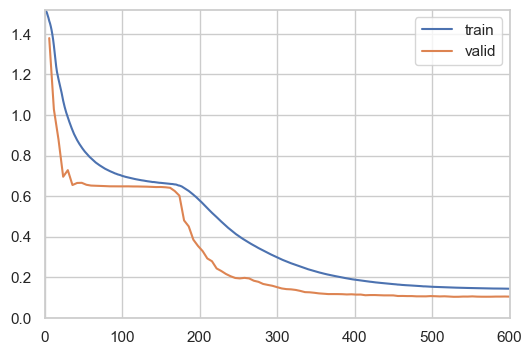

Better model found at epoch 1 with valid_loss value: 1.0280803442001343.
Better model found at epoch 2 with valid_loss value: 0.8783078193664551.
Better model found at epoch 3 with valid_loss value: 0.6953812837600708.
Better model found at epoch 5 with valid_loss value: 0.654569149017334.
Better model found at epoch 9 with valid_loss value: 0.6518924236297607.
Better model found at epoch 10 with valid_loss value: 0.6509760022163391.
Better model found at epoch 11 with valid_loss value: 0.6501427888870239.
Better model found at epoch 12 with valid_loss value: 0.6492769718170166.
Better model found at epoch 13 with valid_loss value: 0.6482304930686951.
Better model found at epoch 14 with valid_loss value: 0.6481479406356812.
Better model found at epoch 15 with valid_loss value: 0.6479934453964233.
Better model found at epoch 16 with valid_loss value: 0.6479880809783936.
Better model found at epoch 18 with valid_loss value: 0.6475428342819214.
Better model found at epoch 19 with valid_lo

In [12]:
MODEL_DIR = './models/prototyping4/'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

if os.path.exists(f'{MODEL_DIR}/model.json'):
    with open(f'{MODEL_DIR}/model.json') as f:
        interruptable_info = json.load(f)
else:
    interruptable_info = {
        "fold": 0,
        "epoch": 0
    }
    with open(f'{MODEL_DIR}/model.json', 'x') as f:
        json.dump(interruptable_info, f, indent=4)
learners = []
for idx, (train_index, val_index) in enumerate(skf.split(np.zeros(len(train_ys)), train_ys)):
    if not os.path.exists(f'{MODEL_DIR}/tcn_fold_{idx+1}'):
        os.makedirs(f'{MODEL_DIR}/tcn_fold_{idx+1}')
    tcn_model = TCN(360, 5, [2]*9, 32, 0.125, use_skip_connections=True).cuda()
    # if idx < interruptable_info["fold"]:
    if idx != 3:
        continue
    train_fold_set = Subset(train_set, train_index)
    label_counts = {}
    for label in train_ys[train_index]:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1
    val_fold_set = Subset(train_set, val_index)
    train_fold_loader = DataLoader(train_fold_set, batch_size=8192, shuffle=True, pin_memory=True, num_workers=8, persistent_workers=True)
    val_fold_loader = DataLoader(val_fold_set, batch_size=8192, shuffle=False, pin_memory=True)
    fold_dls = DataLoaders(train_fold_loader, val_fold_loader)
    # fold_dls = DataLoaders(train_fold_loader, test_loader)
    best_model_cb = SaveModelCallback(monitor="valid_loss", fname=f"best")
    every_epoch_save_cb = SaveModelCallback(monitor="valid_loss", fname=f"epoch", every_epoch=True)
    if not os.path.exists(f"{MODEL_DIR}/tcn_fold_{idx+1}"):
        os.makedirs(f"{MODEL_DIR}/tcn_fold_{idx+1}")
    csv_logger = CSVLogger(fname=f"{MODEL_DIR}/tcn_fold_{idx+1}/log.csv", append=True)
    learn = Learner(
        dls=fold_dls,
        model=tcn_model,
        model_dir=f"{MODEL_DIR}/tcn_fold_{idx+1}/",
        loss_func=nn.CrossEntropyLoss(),
        cbs=[MixedPrecision()],
        metrics=[accuracy, fastai_precision_score(average="macro", zero_division=0.0), Recall(average="macro"), F1Score(average="macro")]
    )
    if interruptable_info["epoch"] != 0 and os.path.exists(f"{MODEL_DIR}/tcn_fold_{idx + 1}/epoch_{interruptable_info['epoch'] + 1}.pth"):
        learn = learn.load(f"{MODEL_DIR}/tcn_fold_{idx + 1}/epoch_{interruptable_info['epoch'] + 1}.pth")
    learn.fit_one_cycle(
        n_epoch=100,
        lr_max=3e-2,
        div=10.0,
        start_epoch=interruptable_info["epoch"],
        wd=1e-4,
        cbs=[LogInterruptable(fn=f"{MODEL_DIR}/model.json"), best_model_cb, every_epoch_save_cb, csv_logger, ShowGraphCallback()],
    )
    train_fold_loader._iterator._shutdown_workers()
    learners.append(learn)
    interruptable_info["epoch"] = 0
    interruptable_info["fold"] += 1
    json.dump(interruptable_info, open(f'{MODEL_DIR}/model.json', 'w'), indent=4)

Whoops, setup the TCN wrongly.

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.867072,0.665821,0.813838,0.162768,0.200000,0.179473,00:29
1,0.735483,0.651996,0.813838,0.162768,0.200000,0.179473,00:05
2,0.687933,0.637870,0.813838,0.162768,0.200000,0.179473,00:04
3,0.659825,0.582930,0.814207,0.296191,0.200670,0.180861,00:05
4,0.577221,0.378867,0.890221,0.357738,0.345066,0.349068,00:05
5,0.481783,0.275426,0.923063,0.650498,0.508089,0.547631,00:05
6,0.390928,0.179667,0.948524,0.713325,0.561981,0.608075,00:05
7,0.307469,0.118262,0.964576,0.748427,0.626220,0.671492,00:05
8,0.233278,0.088445,0.976384,0.765596,0.673767,0.710391,00:05
9,0.177730,0.068647,0.982472,0.761944,0.703202,0.728150,00:05


Better model found at epoch 0 with valid_loss value: 0.6658208966255188.


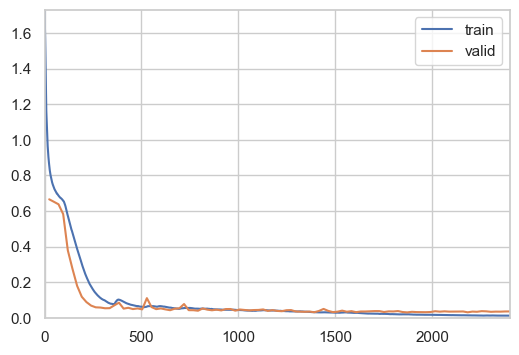

Better model found at epoch 1 with valid_loss value: 0.6519962549209595.
Better model found at epoch 2 with valid_loss value: 0.637869656085968.
Better model found at epoch 3 with valid_loss value: 0.5829297304153442.
Better model found at epoch 4 with valid_loss value: 0.3788667321205139.
Better model found at epoch 5 with valid_loss value: 0.27542608976364136.
Better model found at epoch 6 with valid_loss value: 0.17966747283935547.
Better model found at epoch 7 with valid_loss value: 0.11826241761445999.
Better model found at epoch 8 with valid_loss value: 0.08844491839408875.
Better model found at epoch 9 with valid_loss value: 0.06864742189645767.
Better model found at epoch 10 with valid_loss value: 0.05889134854078293.
Better model found at epoch 11 with valid_loss value: 0.05768393725156784.
Better model found at epoch 12 with valid_loss value: 0.05367261543869972.
Better model found at epoch 16 with valid_loss value: 0.05158821865916252.
Better model found at epoch 18 with val

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.887533,0.660115,0.813838,0.162768,0.200000,0.179473,00:28
1,0.741117,0.644829,0.813838,0.162768,0.200000,0.179473,00:05
2,0.689369,0.634663,0.813838,0.162768,0.200000,0.179473,00:05
3,0.659218,0.575427,0.823247,0.304203,0.223458,0.222101,00:05
4,0.596359,0.379498,0.874908,0.400896,0.364067,0.378106,00:05
5,0.492312,0.247240,0.928413,0.727858,0.441483,0.468946,00:05
6,0.388710,0.153326,0.954982,0.741990,0.568797,0.607237,00:05
7,0.299462,0.102056,0.972694,0.754479,0.640294,0.676254,00:05
8,0.230043,0.081855,0.976199,0.748285,0.682538,0.703271,00:05
9,0.179412,0.066924,0.982657,0.781325,0.679564,0.715705,00:05


Better model found at epoch 0 with valid_loss value: 0.6601153612136841.


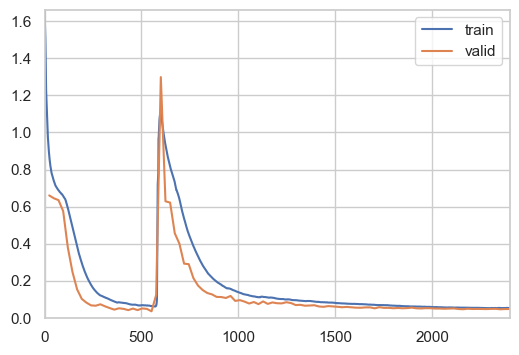

Better model found at epoch 1 with valid_loss value: 0.6448289752006531.
Better model found at epoch 2 with valid_loss value: 0.6346625685691833.
Better model found at epoch 3 with valid_loss value: 0.5754265189170837.
Better model found at epoch 4 with valid_loss value: 0.3794979453086853.
Better model found at epoch 5 with valid_loss value: 0.2472400814294815.
Better model found at epoch 6 with valid_loss value: 0.15332558751106262.
Better model found at epoch 7 with valid_loss value: 0.10205591470003128.
Better model found at epoch 8 with valid_loss value: 0.08185494691133499.
Better model found at epoch 9 with valid_loss value: 0.0669235810637474.
Better model found at epoch 10 with valid_loss value: 0.0652604028582573.
Better model found at epoch 12 with valid_loss value: 0.06195821613073349.
Better model found at epoch 13 with valid_loss value: 0.05263369902968407.
Better model found at epoch 14 with valid_loss value: 0.04405581206083298.
Better model found at epoch 17 with valid

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.873320,0.649618,0.813838,0.162768,0.200000,0.179473,00:28
1,0.733626,0.638066,0.813838,0.162768,0.200000,0.179473,00:05
2,0.683937,0.629013,0.813838,0.162768,0.200000,0.179473,00:05
3,0.653041,0.533181,0.871956,0.323912,0.320880,0.320838,00:05
4,0.557052,0.356232,0.891882,0.376289,0.351838,0.352584,00:05
5,0.452441,0.226071,0.926015,0.526711,0.428572,0.439248,00:05
6,0.353405,0.147690,0.955904,0.720427,0.574234,0.620779,00:05
7,0.267408,0.099180,0.973063,0.764803,0.628007,0.662764,00:05
8,0.201083,0.070872,0.980627,0.747129,0.676302,0.701968,00:05
9,0.153313,0.062932,0.984502,0.750734,0.714802,0.730353,00:05


Better model found at epoch 0 with valid_loss value: 0.6496176719665527.


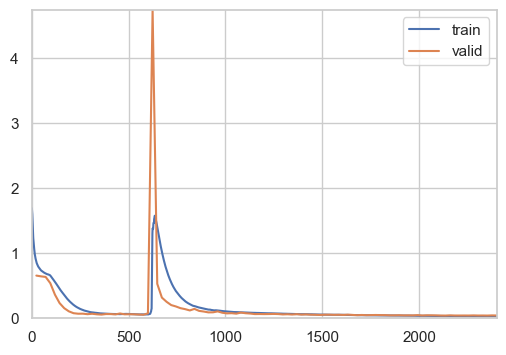

Better model found at epoch 1 with valid_loss value: 0.638066291809082.
Better model found at epoch 2 with valid_loss value: 0.6290132403373718.
Better model found at epoch 3 with valid_loss value: 0.5331814289093018.
Better model found at epoch 4 with valid_loss value: 0.3562317192554474.
Better model found at epoch 5 with valid_loss value: 0.2260705977678299.
Better model found at epoch 6 with valid_loss value: 0.14769048988819122.
Better model found at epoch 7 with valid_loss value: 0.0991804376244545.
Better model found at epoch 8 with valid_loss value: 0.07087242603302002.
Better model found at epoch 9 with valid_loss value: 0.0629320740699768.
Better model found at epoch 11 with valid_loss value: 0.05581025406718254.
Better model found at epoch 13 with valid_loss value: 0.053943801671266556.
Better model found at epoch 14 with valid_loss value: 0.049344126135110855.
Better model found at epoch 23 with valid_loss value: 0.046755868941545486.
Better model found at epoch 61 with val

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.836843,0.649365,0.813838,0.162768,0.200000,0.179473,00:28
1,0.720772,0.637091,0.813838,0.162768,0.200000,0.179473,00:05
2,0.677656,0.627591,0.813838,0.162768,0.200000,0.179473,00:05
3,0.655408,0.616004,0.813838,0.162768,0.200000,0.179473,00:05
4,0.640150,0.599668,0.813838,0.162768,0.200000,0.179473,00:05
5,0.585429,0.345804,0.908856,0.497037,0.396994,0.408194,00:05
6,0.473218,0.187796,0.949631,0.606207,0.513477,0.533589,00:05
7,0.364224,0.120724,0.966790,0.761783,0.587420,0.628679,00:05
8,0.273060,0.088778,0.975461,0.743833,0.662942,0.696899,00:05
9,0.205565,0.056145,0.984317,0.772005,0.700950,0.730025,00:05


Better model found at epoch 0 with valid_loss value: 0.6493645906448364.


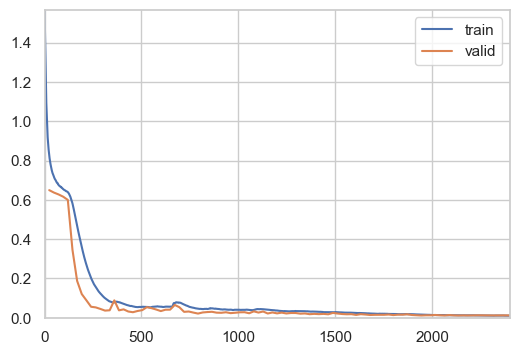

Better model found at epoch 1 with valid_loss value: 0.6370912790298462.
Better model found at epoch 2 with valid_loss value: 0.6275911331176758.
Better model found at epoch 3 with valid_loss value: 0.6160037517547607.
Better model found at epoch 4 with valid_loss value: 0.5996677279472351.
Better model found at epoch 5 with valid_loss value: 0.34580421447753906.
Better model found at epoch 6 with valid_loss value: 0.1877964437007904.
Better model found at epoch 7 with valid_loss value: 0.12072410434484482.
Better model found at epoch 8 with valid_loss value: 0.08877841383218765.
Better model found at epoch 9 with valid_loss value: 0.0561453178524971.
Better model found at epoch 10 with valid_loss value: 0.052975788712501526.
Better model found at epoch 11 with valid_loss value: 0.04515665024518967.
Better model found at epoch 12 with valid_loss value: 0.036646828055381775.
Better model found at epoch 17 with valid_loss value: 0.03202774003148079.
Better model found at epoch 18 with va

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.842101,0.649935,0.813838,0.162768,0.200000,0.179473,00:28
1,0.724193,0.640745,0.813838,0.162768,0.200000,0.179473,00:05
2,0.679728,0.627094,0.813838,0.162768,0.200000,0.179473,00:05
3,0.630522,0.439751,0.852214,0.305838,0.329979,0.312789,00:05
4,0.499927,0.211417,0.940406,0.535208,0.475478,0.492811,00:05
5,0.378658,0.142806,0.962731,0.703689,0.594629,0.626683,00:05
6,0.285019,0.101953,0.970295,0.748244,0.623031,0.661794,00:05
7,0.215436,0.081427,0.977306,0.766719,0.657964,0.696112,00:05
8,0.163786,0.057706,0.984317,0.758461,0.711589,0.732075,00:05
9,0.127891,0.048445,0.987269,0.763454,0.724730,0.741454,00:05


Better model found at epoch 0 with valid_loss value: 0.649935245513916.


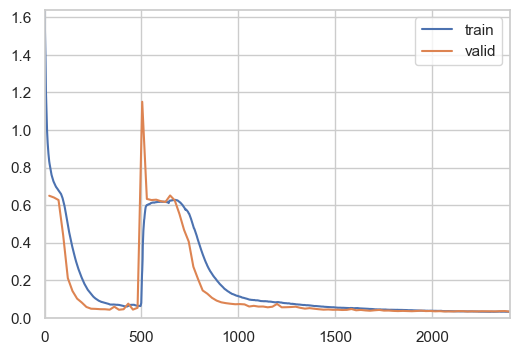

Better model found at epoch 1 with valid_loss value: 0.6407450437545776.
Better model found at epoch 2 with valid_loss value: 0.6270942687988281.
Better model found at epoch 3 with valid_loss value: 0.43975114822387695.
Better model found at epoch 4 with valid_loss value: 0.21141719818115234.
Better model found at epoch 5 with valid_loss value: 0.1428055614233017.
Better model found at epoch 6 with valid_loss value: 0.10195264220237732.
Better model found at epoch 7 with valid_loss value: 0.0814269557595253.
Better model found at epoch 8 with valid_loss value: 0.057706307619810104.
Better model found at epoch 9 with valid_loss value: 0.04844515770673752.
Better model found at epoch 10 with valid_loss value: 0.04750777408480644.
Better model found at epoch 11 with valid_loss value: 0.04584498703479767.
Better model found at epoch 12 with valid_loss value: 0.04551684856414795.
Better model found at epoch 13 with valid_loss value: 0.04322951287031174.
Better model found at epoch 15 with v

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.877666,0.660277,0.813838,0.162768,0.200000,0.179473,00:28
1,0.737294,0.643422,0.813838,0.162768,0.200000,0.179473,00:05
2,0.687416,0.631572,0.813838,0.162768,0.200000,0.179473,00:05
3,0.659245,0.612162,0.813838,0.162768,0.200000,0.179473,00:05
4,0.605654,0.480988,0.870664,0.366132,0.304052,0.320808,00:05
5,0.533435,0.379247,0.893911,0.407311,0.350875,0.356351,00:05
6,0.463596,0.314862,0.896125,0.461531,0.362593,0.371376,00:05
7,0.391268,0.207792,0.938930,0.626448,0.502133,0.535764,00:05
8,0.314731,0.141279,0.959410,0.715956,0.625231,0.654068,00:05
9,0.244000,0.099749,0.975830,0.732914,0.679685,0.700134,00:05


Better model found at epoch 0 with valid_loss value: 0.6602774858474731.


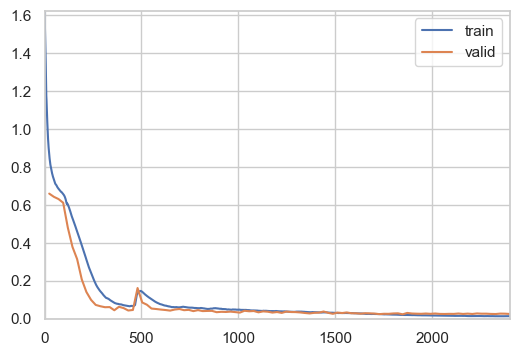

Better model found at epoch 1 with valid_loss value: 0.6434216499328613.
Better model found at epoch 2 with valid_loss value: 0.6315715312957764.
Better model found at epoch 3 with valid_loss value: 0.6121622323989868.
Better model found at epoch 4 with valid_loss value: 0.4809879660606384.
Better model found at epoch 5 with valid_loss value: 0.3792465925216675.
Better model found at epoch 6 with valid_loss value: 0.31486159563064575.
Better model found at epoch 7 with valid_loss value: 0.20779171586036682.
Better model found at epoch 8 with valid_loss value: 0.14127930998802185.
Better model found at epoch 9 with valid_loss value: 0.09974947571754456.
Better model found at epoch 10 with valid_loss value: 0.0732557475566864.
Better model found at epoch 11 with valid_loss value: 0.0662543922662735.
Better model found at epoch 12 with valid_loss value: 0.061133500188589096.
Better model found at epoch 14 with valid_loss value: 0.045149870216846466.
Better model found at epoch 17 with val

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.846839,0.645905,0.813838,0.162768,0.200000,0.179473,00:28
1,0.724594,0.635675,0.813838,0.162768,0.200000,0.179473,00:05
2,0.679258,0.627135,0.813838,0.162768,0.200000,0.179473,00:05
3,0.642468,0.490086,0.854059,0.302171,0.321696,0.311581,00:05
4,0.548185,0.336014,0.895387,0.387846,0.355003,0.358218,00:05
5,0.454223,0.240221,0.926937,0.703013,0.438152,0.464049,00:05
6,0.354677,0.130431,0.964576,0.740964,0.606622,0.648821,00:05
7,0.265352,0.089048,0.976015,0.754999,0.650954,0.689851,00:05
8,0.197984,0.065993,0.982841,0.763108,0.675098,0.708772,00:05
9,0.151519,0.059078,0.983948,0.769732,0.684369,0.713599,00:05


Better model found at epoch 0 with valid_loss value: 0.6459048986434937.


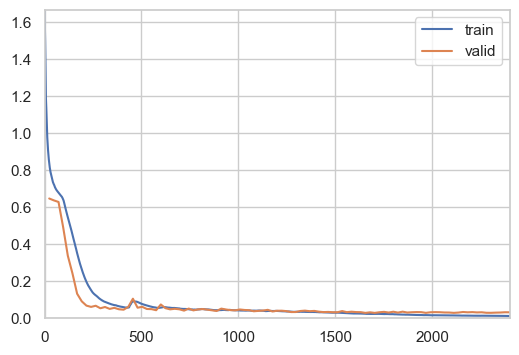

Better model found at epoch 1 with valid_loss value: 0.6356749534606934.
Better model found at epoch 2 with valid_loss value: 0.6271345019340515.
Better model found at epoch 3 with valid_loss value: 0.49008631706237793.
Better model found at epoch 4 with valid_loss value: 0.33601370453834534.
Better model found at epoch 5 with valid_loss value: 0.24022093415260315.
Better model found at epoch 6 with valid_loss value: 0.13043147325515747.
Better model found at epoch 7 with valid_loss value: 0.08904776722192764.
Better model found at epoch 8 with valid_loss value: 0.06599277257919312.
Better model found at epoch 9 with valid_loss value: 0.05907837674021721.
Better model found at epoch 11 with valid_loss value: 0.05164244398474693.
Better model found at epoch 13 with valid_loss value: 0.04828442633152008.
Better model found at epoch 15 with valid_loss value: 0.04618492349982262.
Better model found at epoch 16 with valid_loss value: 0.04389674961566925.
Better model found at epoch 23 with 

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.849903,0.647861,0.813838,0.162768,0.200000,0.179473,00:31
1,0.725258,0.640880,0.813838,0.162768,0.200000,0.179473,00:05
2,0.681726,0.631546,0.813838,0.162768,0.200000,0.179473,00:05
3,0.656083,0.599922,0.813653,0.162761,0.199955,0.179451,00:05
4,0.594736,0.369163,0.886162,0.426152,0.393260,0.405992,00:05
5,0.484364,0.243608,0.921033,0.685644,0.415592,0.431466,00:05
6,0.383591,0.160619,0.955720,0.743919,0.559562,0.607679,00:05
7,0.291449,0.105814,0.971587,0.766104,0.619167,0.654998,00:05
8,0.219519,0.080217,0.977860,0.743572,0.669602,0.699198,00:05
9,0.167613,0.069383,0.983026,0.766659,0.685655,0.712328,00:05


Better model found at epoch 0 with valid_loss value: 0.6478613018989563.


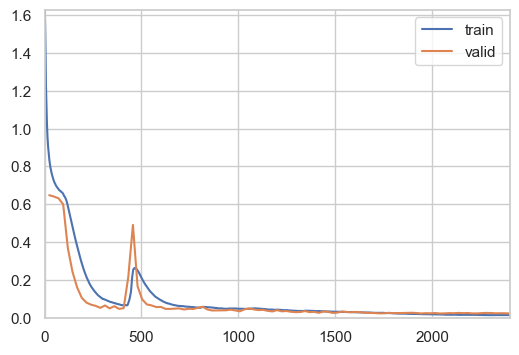

Better model found at epoch 1 with valid_loss value: 0.6408799290657043.
Better model found at epoch 2 with valid_loss value: 0.6315463781356812.
Better model found at epoch 3 with valid_loss value: 0.5999216437339783.
Better model found at epoch 4 with valid_loss value: 0.3691630959510803.
Better model found at epoch 5 with valid_loss value: 0.2436077892780304.
Better model found at epoch 6 with valid_loss value: 0.16061903536319733.
Better model found at epoch 7 with valid_loss value: 0.10581378638744354.
Better model found at epoch 8 with valid_loss value: 0.0802173763513565.
Better model found at epoch 9 with valid_loss value: 0.06938325613737106.
Better model found at epoch 10 with valid_loss value: 0.06291396915912628.
Better model found at epoch 11 with valid_loss value: 0.052513740956783295.
Better model found at epoch 13 with valid_loss value: 0.049832236021757126.
Better model found at epoch 15 with valid_loss value: 0.047287680208683014.
Better model found at epoch 25 with v

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.844424,0.648881,0.813653,0.162731,0.200000,0.179451,00:28
1,0.725525,0.638568,0.813653,0.162731,0.200000,0.179451,00:05
2,0.680884,0.633027,0.813653,0.162731,0.200000,0.179451,00:05
3,0.657418,0.621211,0.813653,0.162731,0.200000,0.179451,00:05
4,0.594469,0.399278,0.888745,0.434976,0.355767,0.377166,00:05
5,0.500860,0.312494,0.904613,0.506937,0.387988,0.404564,00:05
6,0.402487,0.171022,0.952399,0.693909,0.608383,0.632782,00:05
7,0.309707,0.111856,0.971402,0.767312,0.619775,0.664055,00:05
8,0.230611,0.072930,0.980443,0.768129,0.675010,0.709987,00:05
9,0.171475,0.057857,0.984686,0.768330,0.691611,0.719893,00:05


Better model found at epoch 0 with valid_loss value: 0.6488807201385498.


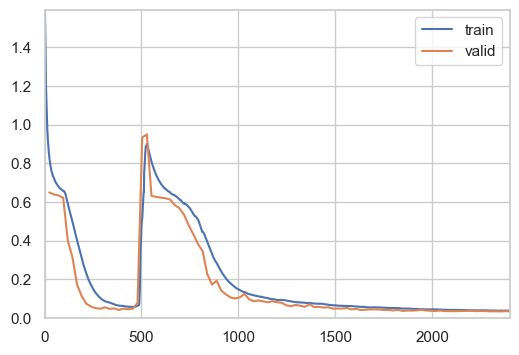

Better model found at epoch 1 with valid_loss value: 0.6385676860809326.
Better model found at epoch 2 with valid_loss value: 0.6330274939537048.
Better model found at epoch 3 with valid_loss value: 0.6212106943130493.
Better model found at epoch 4 with valid_loss value: 0.39927783608436584.
Better model found at epoch 5 with valid_loss value: 0.3124936819076538.
Better model found at epoch 6 with valid_loss value: 0.17102208733558655.
Better model found at epoch 7 with valid_loss value: 0.11185616999864578.
Better model found at epoch 8 with valid_loss value: 0.07292970269918442.
Better model found at epoch 9 with valid_loss value: 0.057856641709804535.
Better model found at epoch 10 with valid_loss value: 0.04991301894187927.
Better model found at epoch 11 with valid_loss value: 0.046752844005823135.
Better model found at epoch 13 with valid_loss value: 0.04645248502492905.
Better model found at epoch 15 with valid_loss value: 0.04061201214790344.
Better model found at epoch 67 with 

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.867713,0.654750,0.813653,0.162731,0.200000,0.179451,00:28
1,0.735295,0.647343,0.813653,0.162731,0.200000,0.179451,00:05
2,0.685805,0.632430,0.813653,0.162731,0.200000,0.179451,00:05
3,0.641117,0.545912,0.831550,0.318518,0.242634,0.249717,00:05
4,0.561089,0.285848,0.917159,0.502717,0.410657,0.419091,00:05
5,0.431517,0.178661,0.954059,0.702199,0.559956,0.587079,00:05
6,0.326605,0.125904,0.966974,0.744011,0.622612,0.652412,00:05
7,0.245027,0.089182,0.975092,0.744543,0.682569,0.706507,00:05
8,0.185971,0.073341,0.980074,0.760750,0.677834,0.708531,00:05
9,0.144997,0.061399,0.984317,0.764731,0.707832,0.730000,00:05


Better model found at epoch 0 with valid_loss value: 0.6547501087188721.


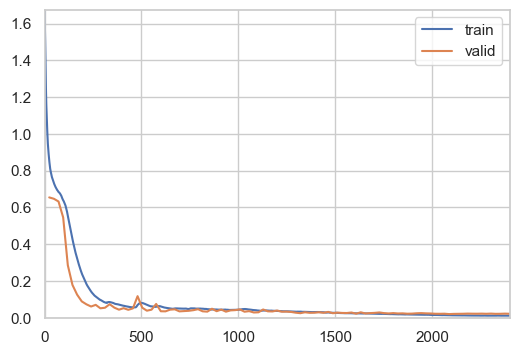

Better model found at epoch 1 with valid_loss value: 0.6473429203033447.
Better model found at epoch 2 with valid_loss value: 0.6324303150177002.
Better model found at epoch 3 with valid_loss value: 0.5459116101264954.
Better model found at epoch 4 with valid_loss value: 0.2858479619026184.
Better model found at epoch 5 with valid_loss value: 0.17866140604019165.
Better model found at epoch 6 with valid_loss value: 0.12590374052524567.
Better model found at epoch 7 with valid_loss value: 0.08918194472789764.
Better model found at epoch 8 with valid_loss value: 0.0733412504196167.
Better model found at epoch 9 with valid_loss value: 0.06139851734042168.
Better model found at epoch 11 with valid_loss value: 0.0516464002430439.
Better model found at epoch 15 with valid_loss value: 0.04420560598373413.
Better model found at epoch 17 with valid_loss value: 0.04353579133749008.
Better model found at epoch 21 with valid_loss value: 0.03868178278207779.
Better model found at epoch 24 with vali

In [10]:
MODEL_DIR = './models/prototyping5/'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

if os.path.exists(f'{MODEL_DIR}/model.json'):
    with open(f'{MODEL_DIR}/model.json') as f:
        interruptable_info = json.load(f)
else:
    interruptable_info = {
        "fold": 0,
        "epoch": 0
    }
    with open(f'{MODEL_DIR}/model.json', 'x') as f:
        json.dump(interruptable_info, f, indent=4)
learners = []
for idx, (train_index, val_index) in enumerate(skf.split(np.zeros(len(train_ys)), train_ys)):
    if not os.path.exists(f'{MODEL_DIR}/tcn_fold_{idx+1}'):
        os.makedirs(f'{MODEL_DIR}/tcn_fold_{idx+1}')
    tcn_model = TCN(360, 5, [32]*9, 2, 0.125, use_skip_connections=True).cuda()
    if idx < interruptable_info["fold"]:
        continue
    train_fold_set = Subset(train_set, train_index)
    label_counts = {}
    for label in train_ys[train_index]:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1
    val_fold_set = Subset(train_set, val_index)
    train_fold_loader = DataLoader(train_fold_set, batch_size=2048, shuffle=True, pin_memory=True, num_workers=8, persistent_workers=True)
    val_fold_loader = DataLoader(val_fold_set, batch_size=2048, shuffle=False, pin_memory=True)
    fold_dls = DataLoaders(train_fold_loader, val_fold_loader)
    # fold_dls = DataLoaders(train_fold_loader, test_loader)
    best_model_cb = SaveModelCallback(monitor="valid_loss", fname=f"best")
    every_epoch_save_cb = SaveModelCallback(monitor="valid_loss", fname=f"epoch", every_epoch=True)
    if not os.path.exists(f"{MODEL_DIR}/tcn_fold_{idx+1}"):
        os.makedirs(f"{MODEL_DIR}/tcn_fold_{idx+1}")
    csv_logger = CSVLogger(fname=f"{MODEL_DIR}/tcn_fold_{idx+1}/log.csv", append=True)
    learn = Learner(
        dls=fold_dls,
        model=tcn_model,
        model_dir=f"{MODEL_DIR}/tcn_fold_{idx+1}/",
        loss_func=nn.CrossEntropyLoss(),
        cbs=[MixedPrecision()],
        metrics=[accuracy, fastai_precision_score(average="macro", zero_division=0.0), Recall(average="macro"), F1Score(average="macro")]
    )
    if interruptable_info["epoch"] != 0 and os.path.exists(f"{MODEL_DIR}/tcn_fold_{idx + 1}/epoch_{interruptable_info['epoch'] + 1}.pth"):
        learn = learn.load(f"{MODEL_DIR}/tcn_fold_{idx + 1}/epoch_{interruptable_info['epoch'] + 1}.pth")
    learn.fit_one_cycle(
        n_epoch=100,
        lr_max=3e-2,
        div=10.0,
        start_epoch=interruptable_info["epoch"],
        wd=1e-4,
        cbs=[LogInterruptable(fn=f"{MODEL_DIR}/model.json"), best_model_cb, every_epoch_save_cb, csv_logger, ShowGraphCallback()],
    )
    train_fold_loader._iterator._shutdown_workers()
    learners.append(learn)
    interruptable_info["epoch"] = 0
    interruptable_info["fold"] += 1
    json.dump(interruptable_info, open(f'{MODEL_DIR}/model.json', 'w'), indent=4)

Change lr and wd

In [ ]:
MODEL_DIR = './models/prototyping6/'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

if os.path.exists(f'{MODEL_DIR}/model.json'):
    with open(f'{MODEL_DIR}/model.json') as f:
        interruptable_info = json.load(f)
else:
    interruptable_info = {
        "fold": 0,
        "epoch": 0
    }
    with open(f'{MODEL_DIR}/model.json', 'x') as f:
        json.dump(interruptable_info, f, indent=4)
learners = []
for idx, (train_index, val_index) in enumerate(skf.split(np.zeros(len(train_ys)), train_ys)):
    if not os.path.exists(f'{MODEL_DIR}/tcn_fold_{idx+1}'):
        os.makedirs(f'{MODEL_DIR}/tcn_fold_{idx+1}')
    tcn_model = TCN(360, 5, [32]*9, 2, 0.125, use_skip_connections=True).cuda()
    if idx < interruptable_info["fold"]:
        continue
    train_fold_set = Subset(train_set, train_index)
    label_counts = {}
    for label in train_ys[train_index]:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1
    val_fold_set = Subset(train_set, val_index)
    train_fold_loader = DataLoader(train_fold_set, batch_size=2048, shuffle=True, pin_memory=True, num_workers=8, persistent_workers=True)
    val_fold_loader = DataLoader(val_fold_set, batch_size=2048, shuffle=False, pin_memory=True)
    fold_dls = DataLoaders(train_fold_loader, val_fold_loader)
    # fold_dls = DataLoaders(train_fold_loader, test_loader)
    best_model_cb = SaveModelCallback(monitor="valid_loss", fname=f"best")
    every_epoch_save_cb = SaveModelCallback(monitor="valid_loss", fname=f"epoch", every_epoch=True)
    if not os.path.exists(f"{MODEL_DIR}/tcn_fold_{idx+1}"):
        os.makedirs(f"{MODEL_DIR}/tcn_fold_{idx+1}")
    csv_logger = CSVLogger(fname=f"{MODEL_DIR}/tcn_fold_{idx+1}/log.csv", append=True)
    learn = Learner(
        dls=fold_dls,
        model=tcn_model,
        model_dir=f"{MODEL_DIR}/tcn_fold_{idx+1}/",
        loss_func=nn.CrossEntropyLoss(),
        cbs=[MixedPrecision()],
        metrics=[accuracy, fastai_precision_score(average="macro", zero_division=0.0), Recall(average="macro"), F1Score(average="macro")]
    )
    if interruptable_info["epoch"] != 0 and os.path.exists(f"{MODEL_DIR}/tcn_fold_{idx + 1}/epoch_{interruptable_info['epoch'] + 1}.pth"):
        learn = learn.load(f"{MODEL_DIR}/tcn_fold_{idx + 1}/epoch_{interruptable_info['epoch'] + 1}.pth")
    learn.fit_one_cycle(
        n_epoch=100,
        lr_max=3e-3,
        div=10.0,
        start_epoch=interruptable_info["epoch"],
        wd=1e-5,
        cbs=[LogInterruptable(fn=f"{MODEL_DIR}/model.json"), best_model_cb, every_epoch_save_cb, csv_logger, ShowGraphCallback()],
    )
    train_fold_loader._iterator._shutdown_workers()
    learners.append(learn)
    interruptable_info["epoch"] = 0
    interruptable_info["fold"] += 1
    json.dump(interruptable_info, open(f'{MODEL_DIR}/model.json', 'w'), indent=4)

In [11]:
torch.cuda.empty_cache()